# PythonË≥áÊñôÂàÜÊûêËàáÊ©üÂô®Â≠∏ÁøíÊáâÁî® Final Project

In [ ]:
!pip install selenium

## Crawling

In [ ]:
import os
import time
import csv
import pickle
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

def save_cookies():
    with open(COOKIES_FILE, "wb") as f:
        pickle.dump(driver.get_cookies(), f)

def load_cookies():
    if not os.path.exists(COOKIES_FILE):
        return False
    driver.get("https://x.com")
    with open(COOKIES_FILE, "rb") as f:
        cookies = pickle.load(f)
    for cookie in cookies:
        if "expiry" in cookie:
            del cookie["expiry"]
        driver.add_cookie(cookie)
    driver.refresh()
    return True

def login_and_save():
    driver.get("https://x.com/login")
    print("Ë´ãÁôªÂÖ•...")
    input("ÊåâEnterÂÑ≤Â≠òcookie")
    save_cookies()
    print("CookiesÂÑ≤Â≠òÊàêÂäü")

webdriver_path = "/opt/homebrew/bin/chromedriver"
service = Service(webdriver_path)
options = Options()
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_argument("--disable-infobars")
options.add_argument("--start-maximized")
options.add_argument("--disable-extensions")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36")

driver = webdriver.Chrome(service=service, options=options)
COOKIES_FILE = "twitter_cookies.pkl"

if not load_cookies():
    login_and_save()
else:
    print("CookiesËá™ÂãïÁôªÂÖ•")

since = "2025-05-09"
until = "2025-05-10"
target_url = f"https://x.com/search?q=tariff%20until%3A{until}%20since%3A{since}&src=typed_query"
driver.get(target_url)
time.sleep(5)

scroll_pause_time = 3
all_tweet_data = []
processed_tweets = set()
count = -1

while len(processed_tweets) != count:
    count = len(processed_tweets)
    try:
        article_elements = driver.find_elements(By.XPATH, '//article[@data-testid="tweet"]')
    except:
        break
    if not article_elements:
        print("ÂÅúÊ≠¢ÔºöÊ≤íÊúâÊâæÂà∞Êõ¥Â§öÊé®Êñá")
        break

    for article in article_elements:
        try:
            tweet_text_element = article.find_element(By.XPATH, './/div[@data-testid="tweetText"]')
            tweet_text = tweet_text_element.text
            if tweet_text in processed_tweets:
                continue
            processed_tweets.add(tweet_text)

            time_element = article.find_element(By.XPATH, './/a/time')
            timestamp_str = time_element.get_attribute('datetime')

            all_tweet_data.append({
                'Timestamp': timestamp_str,
                'Tweet Content': tweet_text,
            })

        except Exception as e:
            print(f"ÊäìÂèñÊé®ÊñáÈåØË™§: {e}")
            continue

    driver.execute_script("window.scrollBy(0, 3000);")
    time.sleep(scroll_pause_time)

date_str = since
csv_file_path = f'tariff_data{date_str.replace("-", "")}.csv'

try:
    with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['Timestamp', 'Tweet Content']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for data in all_tweet_data:
            writer.writerow(data)
    print(f"ÂÑ≤Â≠òÊé®ÊñáËá≥Ôºö{csv_file_path}Ôºà{len(all_tweet_data)}ÂâáÔºâ")
except Exception as e:
    print(f"ÂÑ≤Â≠òÂ§±ÊïóÔºö{e}")

driver.quit()


## Filtering

In [ ]:
import os
import pandas as pd
from langdetect import detect, DetectorFactory

DetectorFactory.seed = 0
folder_path = "data/tariff_data"
filtered_folder = "../data/tariff_data_en"
os.makedirs(filtered_folder, exist_ok=True)

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            df = pd.read_csv(file_path)

            def is_english(text):
                try:
                    return detect(str(text)) == 'en'
                except:
                    return False

            df_en = df[df['Tweet Content'].apply(is_english)]
            output_path = os.path.join(filtered_folder, filename)
            df_en.to_csv(output_path, index=False, encoding='utf-8')
            print(f"ÈÅéÊøæÂÑ≤Â≠òÊàêÂäüËá≥{filename}ÔºàÂâ© {len(df_en)} Á≠ÜÔºâ")
        except Exception as e:
            print(f"Ê™îÊ°à{filename}ÁôºÁîüÈåØË™§Ôºö{e}")


## Feature Extracting

In [ ]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def extract_day_features(df, date_str):
    df = df.copy()
    df["sentiment_score"] = df["sentiment"].map(sentiment_map)
    df["length"] = df["Tweet Content"].astype(str).apply(len)
    df["num_words"] = df["Tweet Content"].astype(str).apply(lambda x: len(x.split()))
    df["num_hashtags"] = df["Tweet Content"].astype(str).str.count("#")
    df["num_mentions"] = df["Tweet Content"].astype(str).str.count("@")
    df["uppercase_ratio"] = df["Tweet Content"].astype(str).apply(
        lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
    df["vader_compound"] = df["Tweet Content"].astype(str).apply(
        lambda x: analyzer.polarity_scores(x)["compound"])

    total = len(df)
    return {
        "date": date_str,
        "num_tweets": total,
        "avg_length": df["length"].mean(),
        "avg_num_words": df["num_words"].mean(),
        "avg_hashtags": df["num_hashtags"].mean(),
        "avg_mentions": df["num_mentions"].mean(),
        "avg_uppercase_ratio": df["uppercase_ratio"].mean(),
        "prop_negative": len(df[df["sentiment"] == "negative"]) / total if total else 0,
        "prop_neutral": len(df[df["sentiment"] == "neutral"]) / total if total else 0,
        "prop_positive": len(df[df["sentiment"] == "positive"]) / total if total else 0,
        "vader_avg_compound": df["vader_compound"].mean(),
        "vader_std_compound": df["vader_compound"].std(),
        "vader_max_compound": df["vader_compound"].max(),
        "vader_min_compound": df["vader_compound"].min(),
        "avg_sentiment_score": df["sentiment_score"].mean(),
        "day_of_week": datetime.strptime(date_str, "%Y-%m-%d").weekday(),
        "is_weekend": 1 if datetime.strptime(date_str, "%Y-%m-%d").weekday() >= 5 else 0
    }

data_folder = "data/tariff_data_en"
analyzer = SentimentIntensityAnalyzer()
sentiment_map = {"negative": 0, "neutral": 1, "positive": 2}

feature_rows = []
for filename in sorted(os.listdir(data_folder)):
    if filename.endswith(".csv"):
        filepath = os.path.join(data_folder, filename)
        try:
            df = pd.read_csv(filepath)
            date_str = filename.replace("tariff_data_", "").replace(".csv", "")
            if "-" not in date_str:
                date_str = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}"
            features = extract_day_features(df, date_str)
            feature_rows.append(features)
        except Exception as e:
            print(f"Ê™îÊ°à{filename}ÁôºÁîüÈåØË™§: {e}")

features_df = pd.DataFrame(feature_rows)
print("ËêÉÂèñÂÆåÊàêÔºö")
print(features_df.head())
features_df.to_csv("daily_sentiment_features.csv", index=False)

‚úÖ ËêÉÂèñÂÆåÊàêÔºå‰ª•‰∏ãÊòØÁâπÂæµÈ†êË¶ΩÔºö
         date  num_tweets  avg_length  avg_num_words  avg_hashtags  \
0  2025-03-01          57  186.807018      27.807018      0.526316   
1  2025-03-02         150  183.986667      27.406667      0.386667   
2  2025-03-03         205  163.819512      25.600000      0.165854   
3  2025-03-04         215  178.246512      27.265116      0.344186   
4  2025-03-05         216  172.273148      26.629630      0.435185   

   avg_mentions  avg_uppercase_ratio  prop_negative  prop_neutral  \
0      0.157895             0.061645       0.614035      0.157895   
1      0.153333             0.072549       0.546667      0.173333   
2      0.112195             0.067358       0.478049      0.234146   
3      0.162791             0.066337       0.460465      0.167442   
4      0.236111             0.061758       0.393519      0.324074   

   prop_positive  vader_avg_compound  vader_std_compound  vader_max_compound  \
0       0.228070           -0.200100    

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("daily_sentiment_features.csv")
df = df.dropna()
df.head()

date  num_tweets  avg_length  avg_num_words  avg_hashtags  \
0  2025-03-01          57  186.807018      27.807018      0.526316   
1  2025-03-02         150  183.986667      27.406667      0.386667   
2  2025-03-03         205  163.819512      25.600000      0.165854   
3  2025-03-04         215  178.246512      27.265116      0.344186   
4  2025-03-05         216  172.273148      26.629630      0.435185   

   avg_mentions  avg_uppercase_ratio  prop_negative  prop_neutral  \
0      0.157895             0.061645       0.614035      0.157895   
1      0.153333             0.072549       0.546667      0.173333   
2      0.112195             0.067358       0.478049      0.234146   
3      0.162791             0.066337       0.460465      0.167442   
4      0.236111             0.061758       0.393519      0.324074   

   prop_positive  vader_avg_compound  vader_std_compound  vader_max_compound  \
0       0.228070           -0.200100            0.484145              0.9309   
1       0.280000           -0.190273            0.445028              0.8122   
2       0.287805           -0.117938            0.429847              0.8625   
3       0.372093           -0.031871            0.534663              0.9081   
4       0.282407           -0.107240            0.473492              0.8834   

   vader_min_compound  avg_sentiment_score  day_of_week  is_weekend  
0             -0.8519             0.614035            5           1  
1             -0.9300             0.733333            6           1  
2             -0.9201             0.809756            0           0  
3             -0.9622             0.911628            1           0  
4             -0.9590             0.888889            2           0

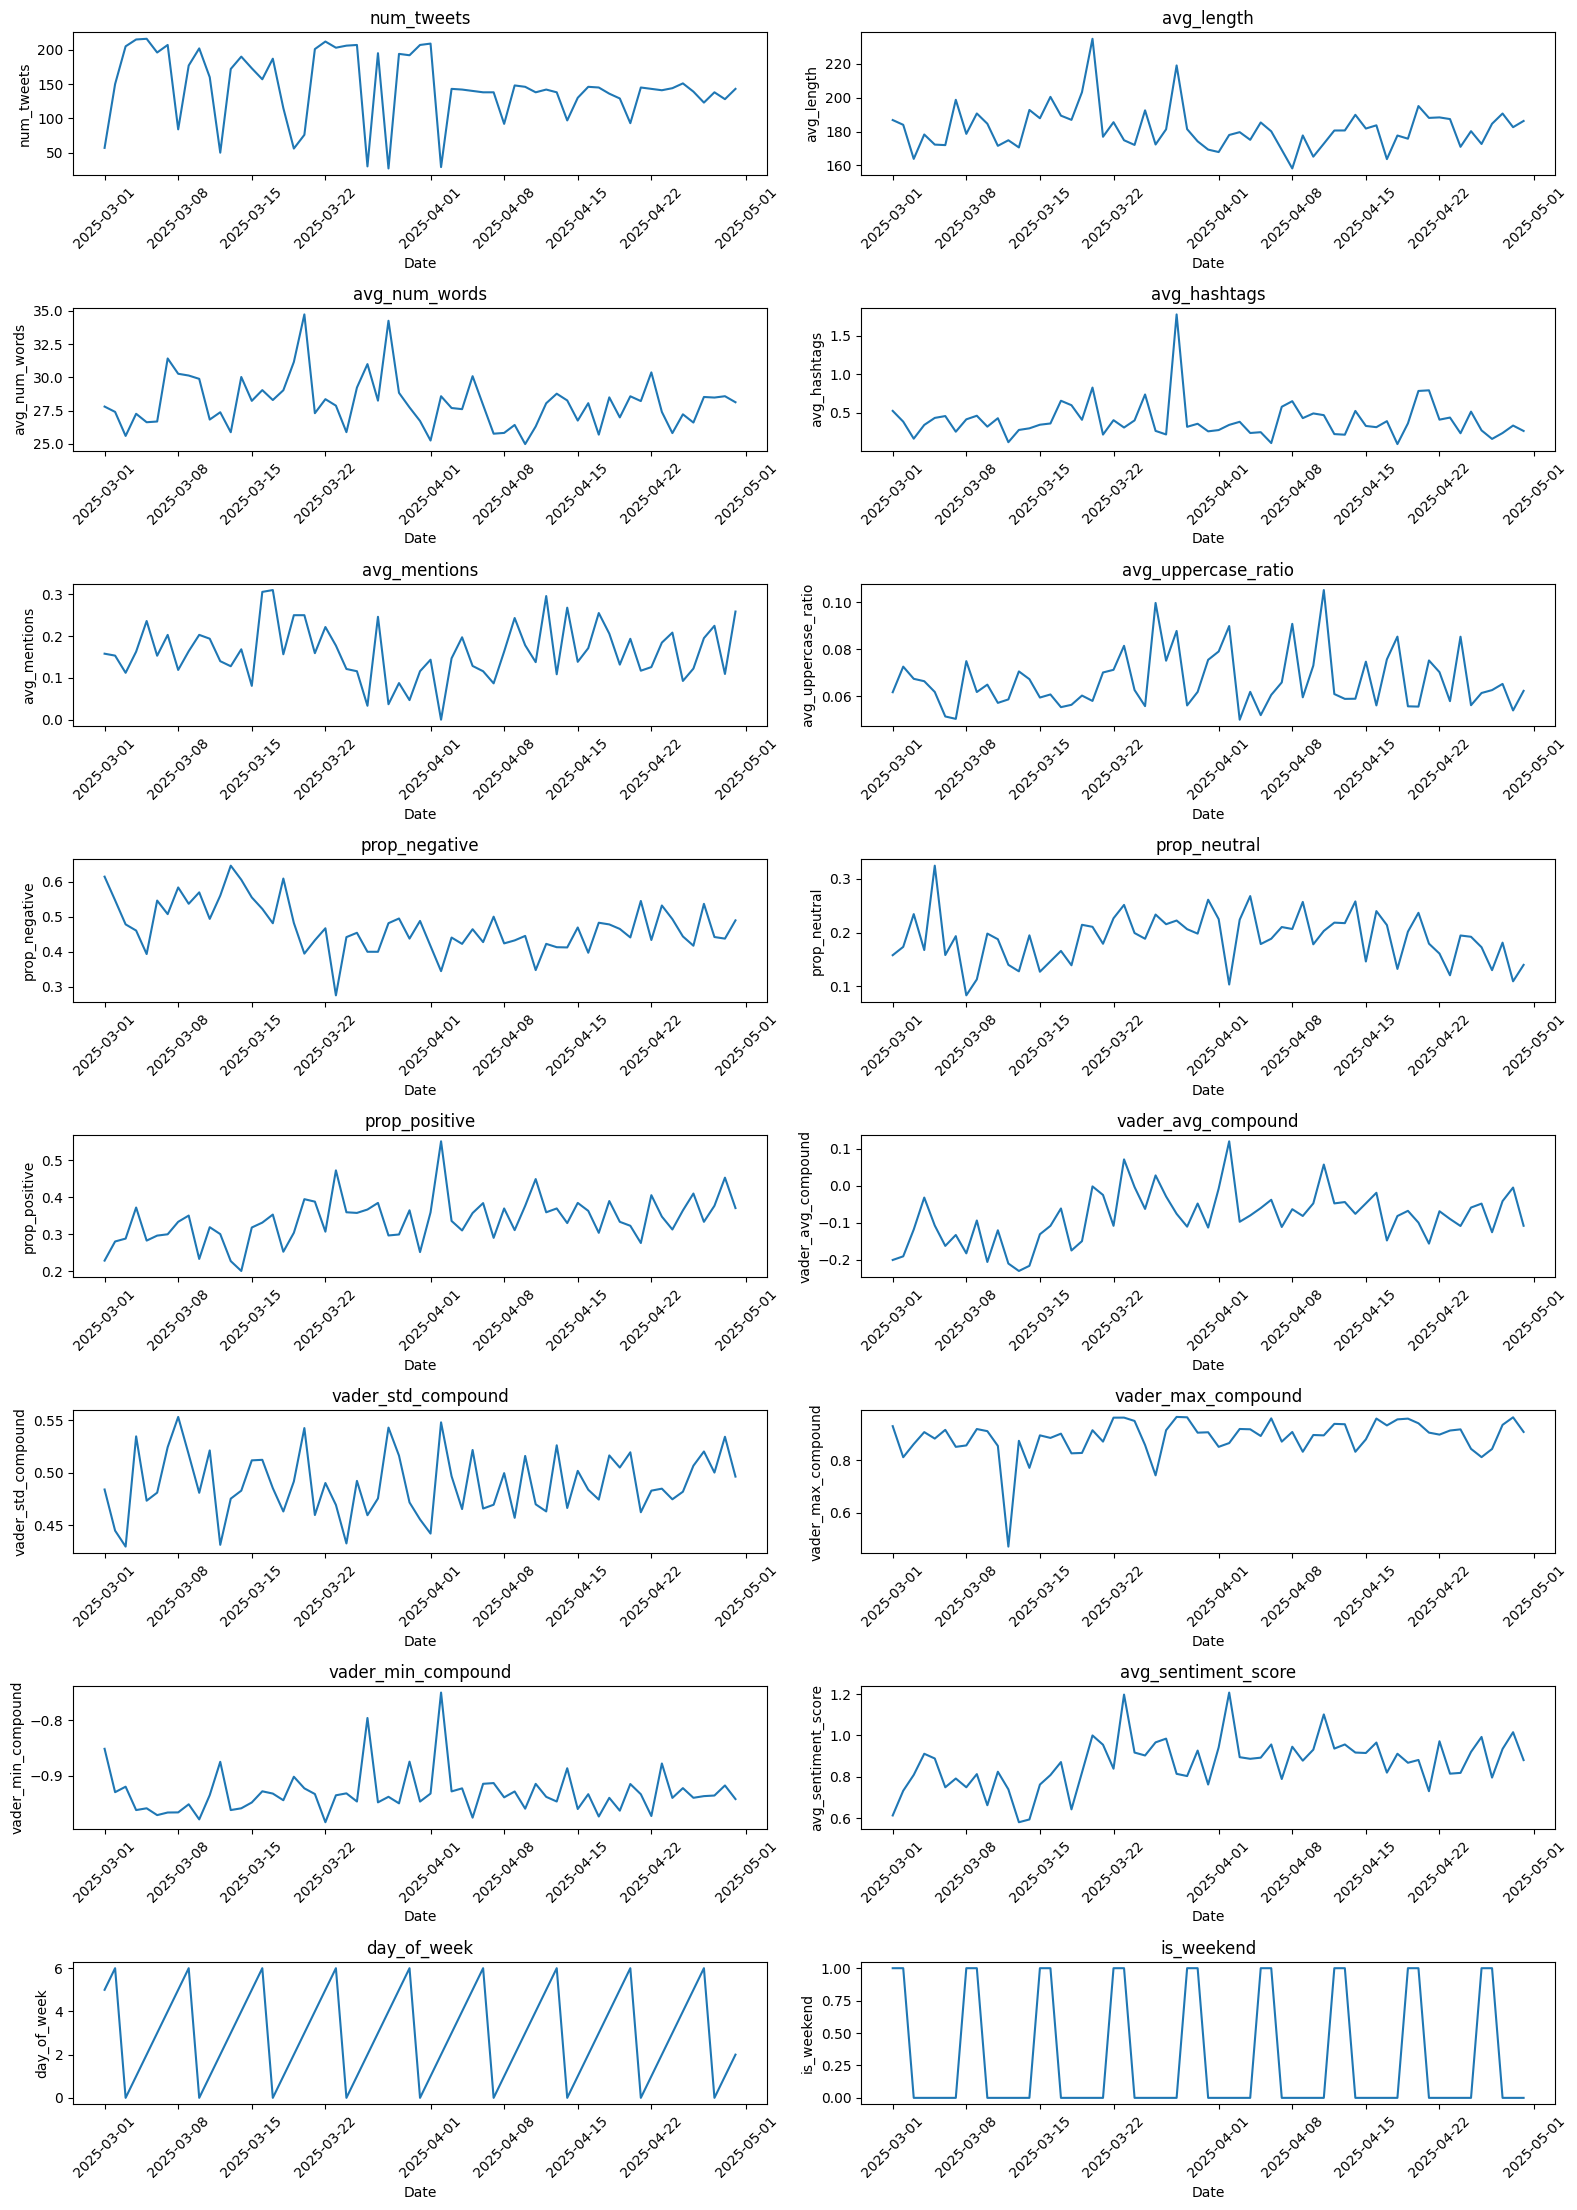

In [ ]:
plt.figure(figsize=(16, 24))
for i, column in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns)//2 + 1, 2, i + 1)
    sns.lineplot(data=df, x=df.index, y=column)
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv("daily_sentiment_features.csv")
df = df.dropna()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df.head()

num_tweets  avg_length  avg_num_words  avg_hashtags  avg_mentions  \
date                                                                            
2025-03-01          57  186.807018      27.807018      0.526316      0.157895   
2025-03-02         150  183.986667      27.406667      0.386667      0.153333   
2025-03-03         205  163.819512      25.600000      0.165854      0.112195   
2025-03-04         215  178.246512      27.265116      0.344186      0.162791   
2025-03-05         216  172.273148      26.629630      0.435185      0.236111   

            avg_uppercase_ratio  prop_negative  prop_neutral  prop_positive  \
date                                                                          
2025-03-01             0.061645       0.614035      0.157895       0.228070   
2025-03-02             0.072549       0.546667      0.173333       0.280000   
2025-03-03             0.067358       0.478049      0.234146       0.287805   
2025-03-04             0.066337       0.460465      0.167442       0.372093   
2025-03-05             0.061758       0.393519      0.324074       0.282407   

            vader_avg_compound  vader_std_compound  vader_max_compound  \
date                                                                     
2025-03-01           -0.200100            0.484145              0.9309   
2025-03-02           -0.190273            0.445028              0.8122   
2025-03-03           -0.117938            0.429847              0.8625   
2025-03-04           -0.031871            0.534663              0.9081   
2025-03-05           -0.107240            0.473492              0.8834   

            vader_min_compound  avg_sentiment_score  day_of_week  is_weekend  
date                                                                          
2025-03-01             -0.8519             0.614035            5           1  
2025-03-02             -0.9300             0.733333            6           1  
2025-03-03             -0.9201             0.809756            0           0  
2025-03-04             -0.9622             0.911628            1           0  
2025-03-05             -0.9590             0.888889            2           0

In [ ]:
for i in range(1, 5): 
    df[f'lag_{i}'] = df['vader_avg_compound'].shift(i)
    
df_cleaned = df.dropna()
len(df)

61


Ê®°ÂûãÊÄßËÉΩË©ï‰º∞ (Ê∏¨Ë©¶ÈõÜ):
ÂùáÊñπÊ†πË™§Â∑Æ (RMSE): 0.0310
R-squared (R¬≤): 0.3854


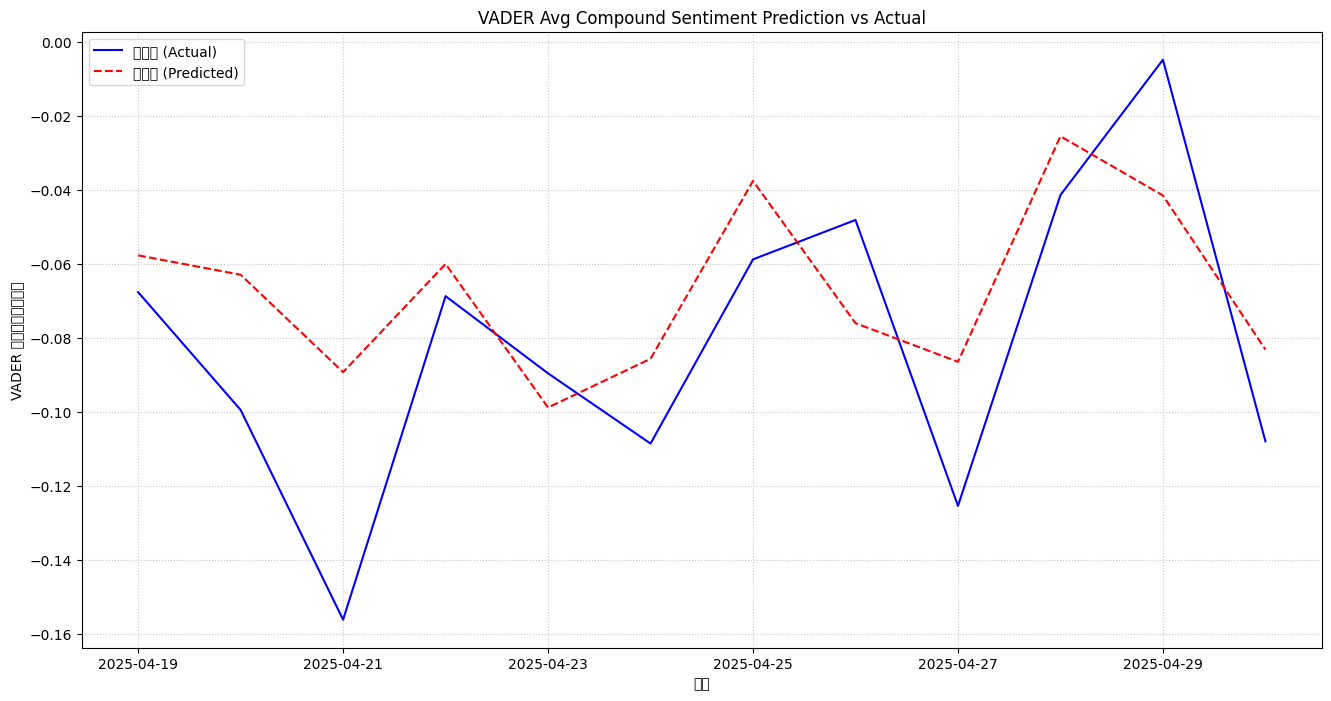


ÁâπÂæµÈáçË¶ÅÊÄß:
  Feature  Importance
3   lag_4    0.304545
2   lag_3    0.302688
0   lag_1    0.228554
1   lag_2    0.164214


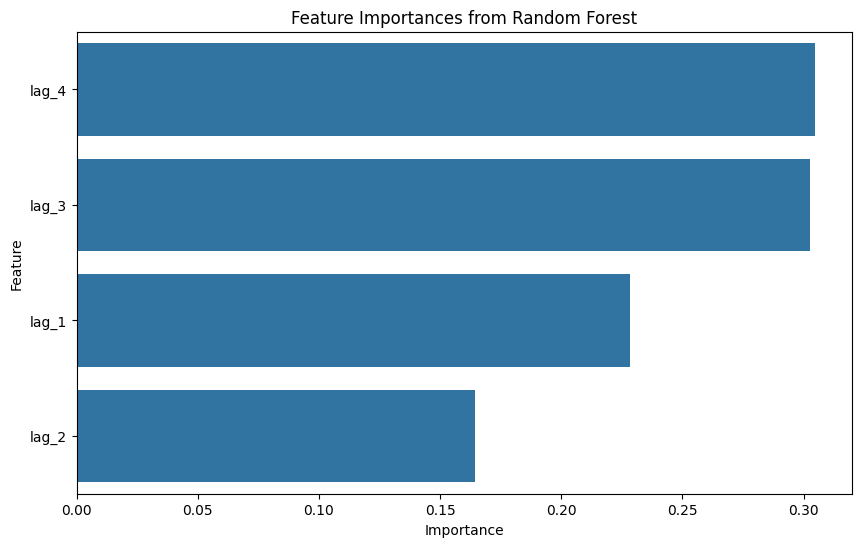

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

train_size = int(len(df_cleaned) * 0.8)
train_df = df_cleaned.iloc[:train_size]
test_df = df_cleaned.iloc[train_size:]

features = [f'lag_{i}' for i in range(1, 5)]
target = 'vader_avg_compound'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]


model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nÊ®°ÂûãÊÄßËÉΩË©ï‰º∞ (Ê∏¨Ë©¶ÈõÜ):")
print(f"ÂùáÊñπÊ†πË™§Â∑Æ (RMSE): {rmse:.4f}")
print(f"R-squared (R¬≤): {r2:.4f}")

plt.figure(figsize=(16, 8))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='red', linestyle='--')
plt.title('VADER Avg Compound Sentiment Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('VADER Average Score')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    feature_names = X_train.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print("\nÁâπÂæµÈáçË¶ÅÊÄß:")
    print(importance_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importances from Random Forest')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

In [12]:
df.columns

Index(['num_tweets', 'avg_length', 'avg_num_words', 'avg_hashtags',
       'avg_mentions', 'avg_uppercase_ratio', 'prop_negative', 'prop_neutral',
       'prop_positive', 'vader_avg_compound', 'vader_std_compound',
       'vader_max_compound', 'vader_min_compound', 'avg_sentiment_score',
       'day_of_week', 'is_weekend', 'lag_1', 'lag_2', 'lag_3', 'lag_4'],
      dtype='object')

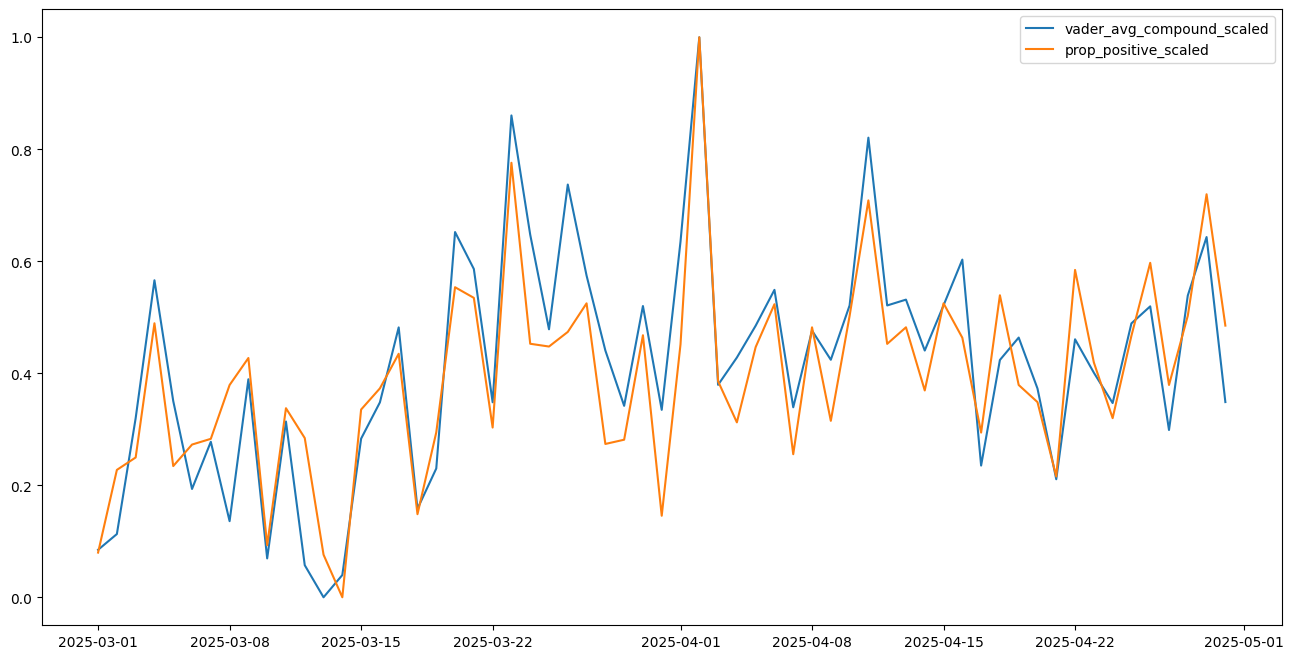

In [ ]:
from sklearn.preprocessing import MinMaxScaler
df['vader_avg_compound_scaled'] = MinMaxScaler().fit_transform(df[['vader_avg_compound']])
df['vader_std_compound_scaled'] = MinMaxScaler().fit_transform(df[['vader_std_compound']])
df['prop_negative_scaled'] = MinMaxScaler().fit_transform(df[['prop_negative']])
df['prop_positive_scaled'] = MinMaxScaler().fit_transform(df[['prop_positive']])

columns=[
'vader_avg_compound_scaled',
'prop_positive_scaled'
]
plt.figure(figsize=(16, 8))
for column in columns:
    plt.plot(df[column],label=column)
plt.legend()

Text(0, 0.5, 'VADER Avg Compound Sentiment Score')

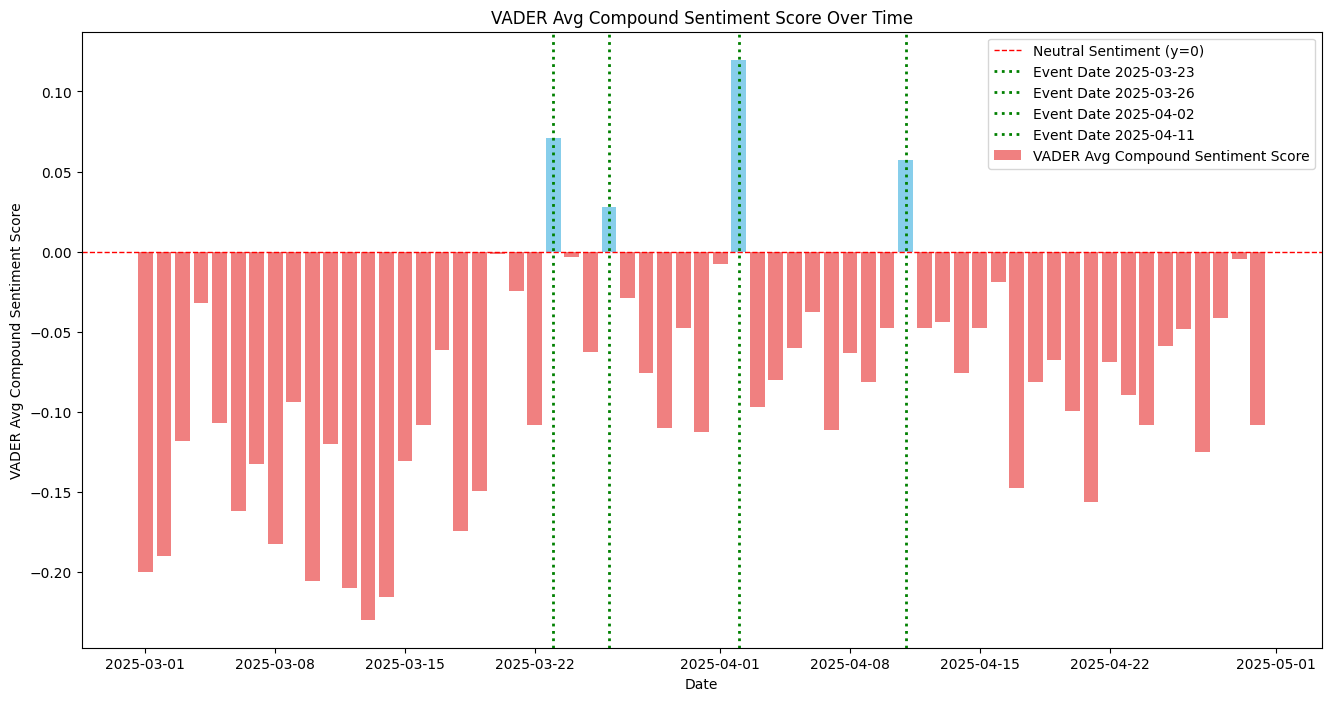

In [ ]:
plt.figure(figsize=(16, 8))
plt.bar(df.index, df['vader_avg_compound'], width=0.8, label='VADER Avg Compound Sentiment Score',
        color=['skyblue' if x >= 0 else 'lightcoral' for x in df['vader_avg_compound']]) # Optional: color based on positive/negative
plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label='Neutral Sentiment (y=0)')
event_date = pd.to_datetime('2025-03-23')
plt.axvline(x=event_date, color='green', linestyle=':', linewidth=2, label='Event Date 2025-03-23')
event_date = pd.to_datetime('2025-03-26')
plt.axvline(x=event_date, color='green', linestyle=':', linewidth=2, label='Event Date 2025-03-26')
event_date = pd.to_datetime('2025-04-02')
plt.axvline(x=event_date, color='green', linestyle=':', linewidth=2, label='Event Date 2025-04-02')
event_date = pd.to_datetime('2025-04-11')
plt.axvline(x=event_date, color='green', linestyle=':', linewidth=2, label='Event Date 2025-04-11')
plt.legend()
plt.title('VADER Avg Compound Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('VADER Avg Compound Sentiment Score')

In [ ]:
import os
import pandas as pd

folder_path = "data/tariff_data_en" 
all_dataframes = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        print(f"ËÆÄÂèñÊ™îÊ°à: {file_path}")

        try:
            df_temp = pd.read_csv(file_path)
            all_dataframes.append(df_temp)
        except Exception as e:
            print(f"Ê™îÊ°à{filename}ÁôºÁîüÈåØË™§: {e}")
            continue

if all_dataframes:
    combined_df = pd.concat(all_dataframes, ignore_index=True)
    print(f"ÊàêÂäüÂêà‰ΩµÔºÅDataFrame Â§ßÂ∞è: {combined_df.shape}")
    print("Ââç 5 Á≠ÜË≥áÊñôÔºö")
    print(combined_df.head())

    initial_rows = combined_df.shape[0]
    combined_df.drop_duplicates(inplace=True)
    rows_after_dedup = combined_df.shape[0]
    if initial_rows > rows_after_dedup:
        print(f"\nÁßªÈô§‰∫Ü {initial_rows - rows_after_dedup} Á≠ÜÈáçË§áË≥áÊñô")
        print(f"ÂéªÈáçÂæå DataFrame Â§ßÂ∞è: {combined_df.shape}")

    output_file_path = "combined_data.csv"
    combined_df.to_csv(output_file_path, index=False)
    print(f"\nÂ∑≤ÂÑ≤Â≠òÂà∞: {output_file_path}")

else:
    print(f"Ë≥áÊñôÂ§æ '{folder_path}' ‰∏≠Ê≤íÊúâÊâæÂà∞CSV Ê™îÊ°à")

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
combined_df["vader_compound"] = combined_df["Tweet Content"].astype(str).apply(
    lambda x: analyzer.polarity_scores(x)["compound"])

combined_df['Timestamp'] = pd.to_datetime(combined_df['Timestamp'])
combined_df.set_index('Timestamp', inplace=True)
combined_df

Tweet Content  \
Timestamp                                                                      
2025-03-01 22:17:49+00:00  Proposed tariffs on China, Canada, and Mexico ...   
2025-03-01 22:27:25+00:00  President Trump says his 25-percent tariff on ...   
2025-03-01 23:00:01+00:00  "You should pay less for someone that has tari...   
2025-03-01 22:30:20+00:00  Beer Companies Say Trump‚Äôs Aluminum Tariff Wil...   
2025-03-01 21:13:00+00:00  Nigerians protesting about MTN increase in tar...   
...                                                                      ...   
2025-03-18 22:52:06+00:00  "McDonald‚Äôs prices ‚Äòto skyrocket‚Äô as main supp...   
2025-03-18 23:01:55+00:00  Trump officials back president's economic poli...   
2025-03-18 21:05:06+00:00  A lot of people are overlooking how something ...   
2025-03-18 22:47:05+00:00           The Trump Tariff Tax will cost everyone.   
2025-03-18 23:14:49+00:00  Astronauts about to learn they have to pay a 2...   

                          sentiment  vader_compound  
Timestamp                                            
2025-03-01 22:17:49+00:00  positive          0.6908  
2025-03-01 22:27:25+00:00  positive          0.6705  
2025-03-01 23:00:01+00:00  negative         -0.7430  
2025-03-01 22:30:20+00:00  negative         -0.5423  
2025-03-01 21:13:00+00:00  negative         -0.1280  
...                             ...             ...  
2025-03-18 22:52:06+00:00  positive          0.4753  
2025-03-18 23:01:55+00:00  negative         -0.3400  
2025-03-18 21:05:06+00:00  positive          0.3612  
2025-03-18 22:47:05+00:00   neutral          0.0000  
2025-03-18 23:14:49+00:00  negative         -0.1027  

[7448 rows x 3 columns]

Text(0, 0.5, 'VADER Compound Sentiment Score')

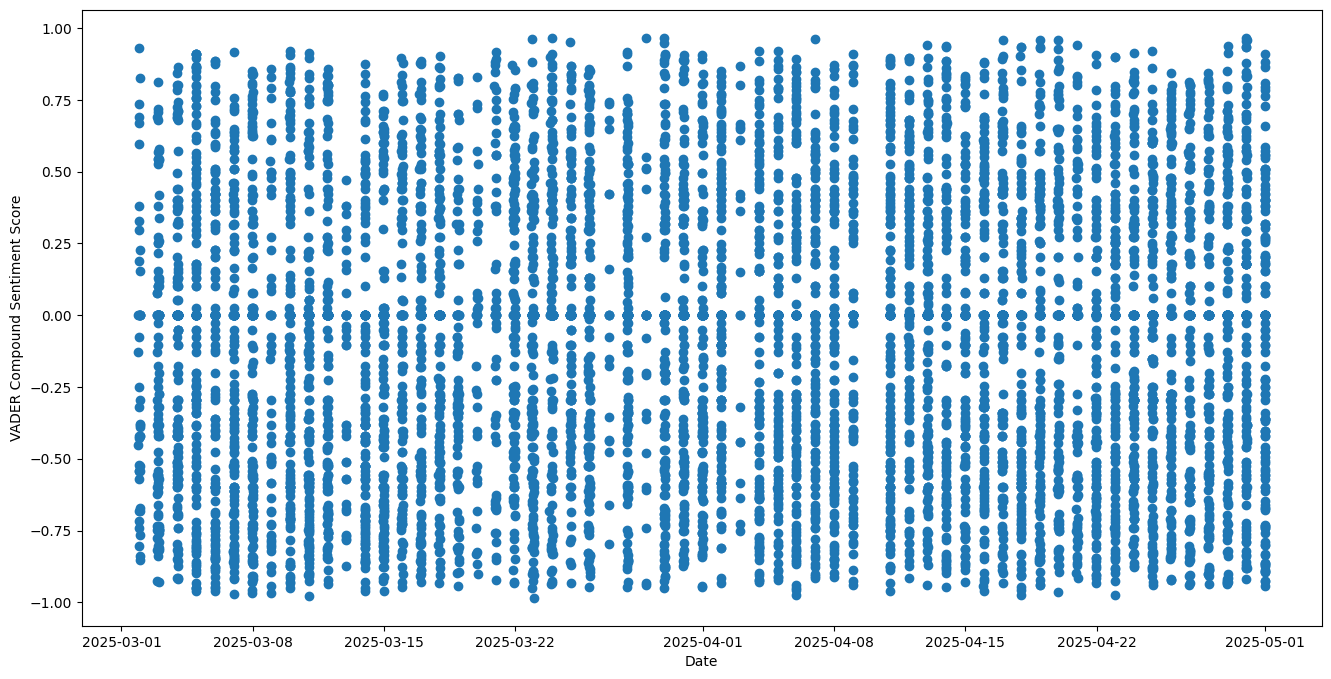

In [20]:
plt.figure(figsize=(16, 8))
plt.scatter(combined_df.index, combined_df['vader_compound'])
plt.xlabel('Date')
plt.ylabel('VADER Compound Sentiment Score')

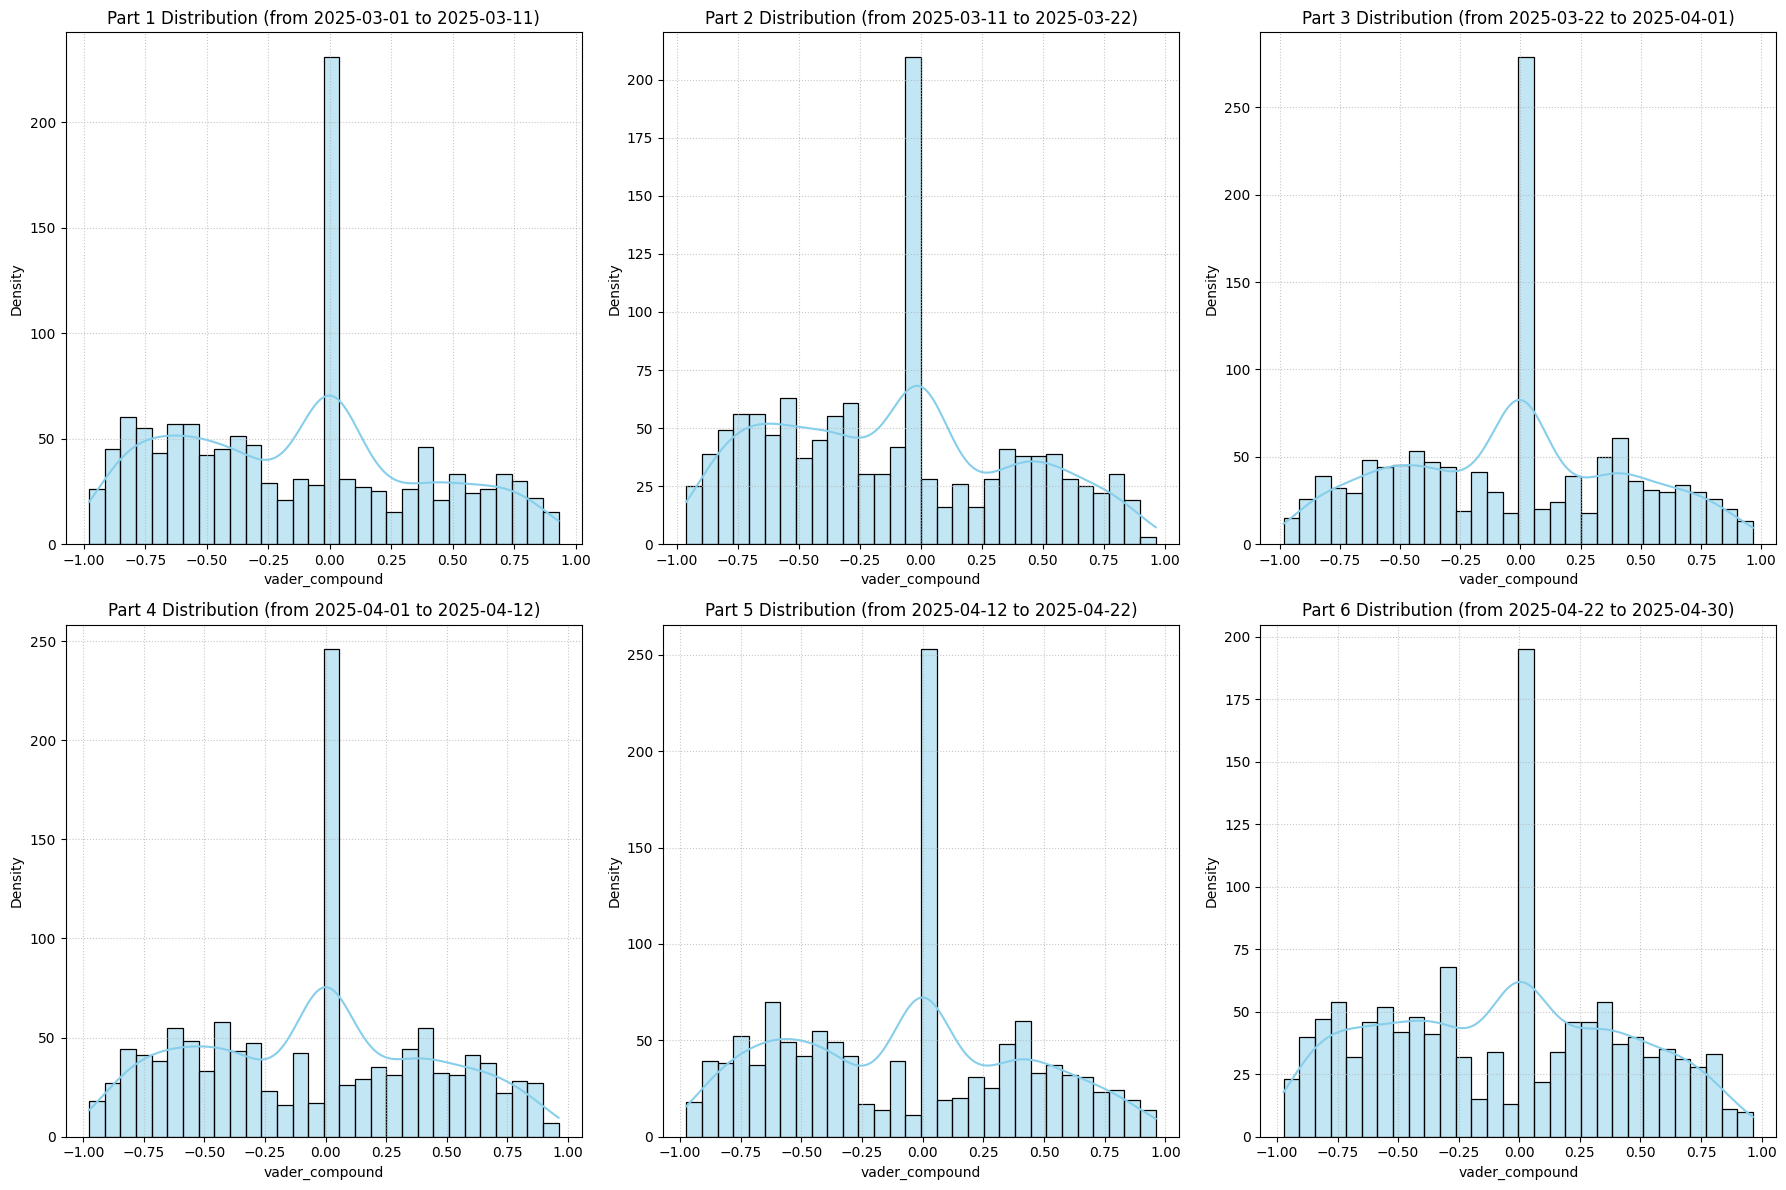

In [ ]:
combined_df=combined_df.sort_index()

num_parts = 6
list_of_dfs = np.array_split(combined_df, num_parts)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12)) 
axes = axes.flatten()

for i, data_part in enumerate(list_of_dfs):
    ax = axes[i]
    sns.histplot(data_part['vader_compound'], kde=True, bins=30, color='skyblue', ax=ax)

    ax.set_title(f'Part {i+1} Distribution (from {data_part.index.min().strftime("%Y-%m-%d")} to {data_part.index.max().strftime("%Y-%m-%d")})')
    ax.set_xlabel('vader_compound')
    ax.set_ylabel('Density')
    ax.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import skew

parts = np.array_split(combined_df, 6)

stats_rows = []
for i, part in enumerate(parts, start=1):
    scores = part["vader_compound"].values
    n        = len(scores)
    mean_val = scores.mean()
    median   = np.median(scores)
    std_val  = scores.std(ddof=0)
    skew_val = skew(scores, bias=False)
    zero_pct = (scores == 0).mean() * 100 
    
    stats_rows.append({
        "ÂçÄÊÆµ": f"Part {i}",
        "N": n,
        "ÂùáÂÄº Œº": round(mean_val, 4),
        "‰∏≠‰ΩçÊï∏": round(median, 4),
        "Ê®ôÊ∫ñÂ∑Æ œÉ": round(std_val, 4),
        "ÂÅèÂ∫¶": round(skew_val, 4),
        "Èõ∂ÂàÜ‰ΩîÊØî (%)": round(zero_pct, 1)
    })

stats_table = pd.DataFrame(stats_rows)
print(stats_table.to_string(index=False))


    ÂçÄÊÆµ    N    ÂùáÂÄº Œº     ‰∏≠‰ΩçÊï∏  Ê®ôÊ∫ñÂ∑Æ œÉ     ÂÅèÂ∫¶  Èõ∂ÂàÜ‰ΩîÊØî (%)
Part 1 1242 -0.1326 -0.0772 0.4993 0.2406      17.8
Part 2 1242 -0.1181 -0.0907 0.4881 0.2295      15.2
Part 3 1241 -0.0386  0.0000 0.4749 0.0566      21.2
Part 4 1241 -0.0522  0.0000 0.4862 0.0654      18.7
Part 5 1241 -0.0799  0.0000 0.4931 0.1213      19.1
Part 6 1241 -0.0737  0.0000 0.4963 0.0657      15.1


In [ ]:
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(parts[0]['vader_compound'], parts[2]['vader_compound'], equal_var=False)
t_stat,p_val

(np.float64(-4.804259814343045), np.float64(1.646077159147644e-06))

In [54]:
from scipy.stats import ks_2samp
ks_2samp(parts[1]['vader_compound'], parts[5]['vader_compound'])

KstestResult(statistic=np.float64(0.07356606860863596), pvalue=np.float64(0.0023188671055809082), statistic_location=np.float64(0.0762), statistic_sign=np.int8(1))

In [ ]:
from scipy.stats import levene
levene(*(p['vader_compound'] for p in parts))

LeveneResult(statistic=np.float64(3.5692094090566493), pvalue=np.float64(0.0031695046648721296))

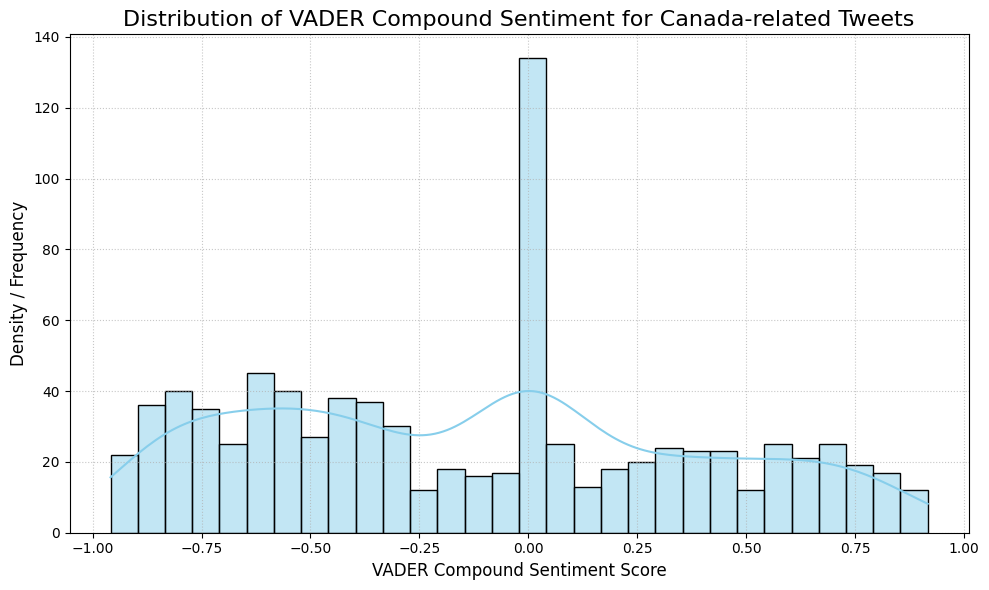

In [ ]:
combined_df_canada = combined_df[combined_df['Tweet Content'].str.contains('Canada|Canadian', case=False, na=False)]

plt.figure(figsize=(10, 6))
sns.histplot(combined_df_canada['vader_compound'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of VADER Compound Sentiment for Canada-related Tweets', fontsize=16)
plt.xlabel('VADER Compound Sentiment Score', fontsize=12)
plt.ylabel('Density / Frequency', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew

scores = combined_df_canada["vader_compound"]

N = len(scores)
mean_val = scores.mean()
median_val = scores.median()
std_val = scores.std(ddof=0)
skew_val = skew(scores, bias=False)
zero_pct = (scores == 0).mean() * 100  # ÁôæÂàÜÊØî

print(f"Ê®£Êú¨Êï∏ N                : {N}")
print(f"Âπ≥ÂùáÂÄº Œº               : {mean_val:.4f}")
print(f"‰∏≠‰ΩçÊï∏                 : {median_val:.4f}")
print(f"Ê®ôÊ∫ñÂ∑Æ œÉ               : {std_val:.4f}")
print(f"ÂÅèÂ∫¶ Skew              : {skew_val:.4f}")
print(f"compound = 0 ÁöÑ‰ΩîÊØî (%) : {zero_pct:.2f}%")


Ê®£Êú¨Êï∏ N                : 849
Âπ≥ÂùáÂÄº Œº               : -0.1261
‰∏≠‰ΩçÊï∏                 : -0.0772
Ê®ôÊ∫ñÂ∑Æ œÉ               : 0.5052
ÂÅèÂ∫¶ Skew              : 0.2284
compound = 0 ÁöÑ‰ΩîÊØî (%) : 15.08%


## Clustering Model

In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer

csv_files = sorted(glob.glob("data/tariff_data_en/*.csv"))
df_list = [pd.read_csv(f) for f in csv_files]
df = pd.concat(df_list, ignore_index=True)
df.head()

Timestamp  \
0  2025-03-01T22:17:49.000Z   
1  2025-03-01T22:27:25.000Z   
2  2025-03-01T23:00:01.000Z   
3  2025-03-01T23:00:01.000Z   
4  2025-03-01T22:30:20.000Z   

                                       Tweet Content sentiment  
0  Proposed tariffs on China, Canada, and Mexico ...  positive  
1  President Trump says his 25-percent tariff on ...  positive  
2  "You should pay less for someone that has tari...  negative  
3  "You should pay less for someone that has tari...  negative  
4  Beer Companies Say Trump‚Äôs Aluminum Tariff Wil...  negative

In [ ]:
df.columns = ['Timestamp', 'text', 'sentiment']
df.dropna(subset=['text'], inplace=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp']) 
event_date = pd.to_datetime("2025-04-02").tz_localize("UTC")
df['period'] = df['Timestamp'].apply(lambda x: 'before' if x < event_date else 'after')

model = SentenceTransformer('all-MiniLM-L6-v2') 
X = model.encode(df['text'].tolist(), show_progress_bar=True)

Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 280/280 [00:17<00:00, 15.89it/s]


Ê≠£Âú®Ë®àÁÆóÊâãËÇòÊ≥ïÊâÄÈúÄÁöÑ WCSS...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


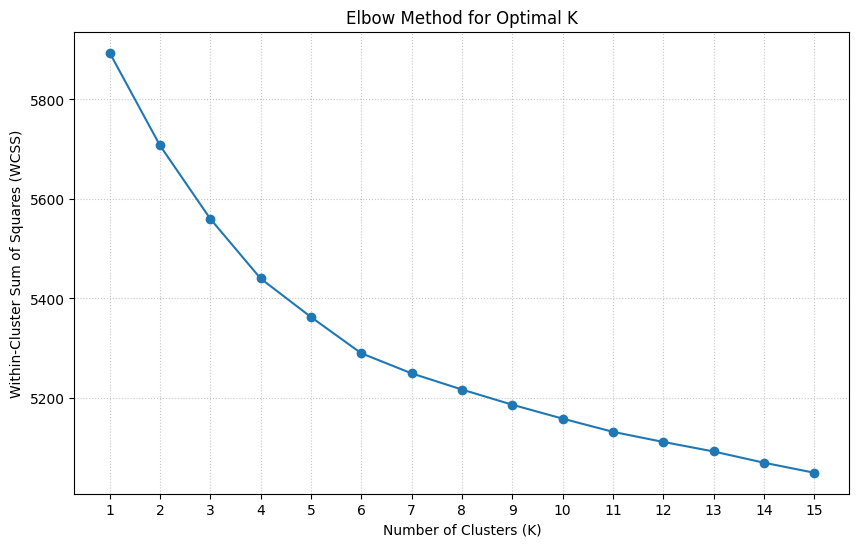

ÊâãËÇòÊ≥ïËß£ÈáãÔºöÂ∞ãÊâæÊõ≤Á∑öÊÄ•Âäá‰∏ãÈôçÂæåËÆäÂæóÂπ≥Á∑©ÁöÑ„ÄåÊâãËÇò„ÄçÈªû„ÄÇ
--------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

wcss = []
max_k = 15
K_range = range(1, max_k + 1)

print("Ë®àÁÆóWCSS")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(K_range)
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

print("-" * 50)

In [ ]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

os.makedirs("saved_imgs", exist_ok=True)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='tab10', alpha=0.6)
plt.title("KMeans with SBERT Embedding (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label='Cluster')
plt.savefig("saved_imgs/kmeans_pca_sbert.png")
plt.close()

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
custom_stopwords = set(['tariff', 'trump'])
all_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stopwords))

def plot_cluster_wordcloud(df, cluster_num):
    text = " ".join(df[df['cluster'] == cluster_num]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=all_stopwords).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Cluster {cluster_num} WordCloud")
    plt.savefig(f"saved_imgs/cluster_{cluster_num}_wordcloud_sbert.png")
    plt.close()

for cl in sorted(df['cluster'].unique()):
    plot_cluster_wordcloud(df, cl)

### üß† Áæ§È´îË™ûÊÑèÁ∏ΩË¶ΩÂàÜÊûê

Êú¨Á†îÁ©∂‰ª• Sentence-BERT Ê®°ÂûãÂ∞áÊé®ÊñáËΩâÊèõÁÇ∫Ë™ûÊÑèÂêëÈáèÔºå‰∏¶ÈÄèÈÅé KMeans ËÅöÈ°ûÊñπÊ≥ïÂ∞áË™ûÊñôÂàÜÁÇ∫ÂÖ≠ÂÄã‰∏ªÈ°åÁæ§„ÄÇÁ∂ìÁî±ÊØèÁæ§È´òÈ†ªË©ûÂΩôÁöÑË©ûÈõ≤Ôºàword cloudÔºâË¶ñË¶∫ÂåñËàáË™ûÊÑèÂ∞çÁÖßÂàÜÊûêÂæåÔºåÊ≠∏Á¥çÂá∫ÂêÑÁæ§ÁöÑÊ†∏ÂøÉË™ûÂ¢ÉËàá‰∏ªÈ°åÂ¶Ç‰∏ãÔºö

- **Cluster 0 ‚Äì ÁæéÂä†Ë≤øÊòìÁà≠Á´ØËàáÂä†ÊãøÂ§ßËßÄÈªû**  
  Ë©≤Áæ§È´îËÅöÁÑ¶ÊñºÂä†ÊãøÂ§ßËàáÁæéÂúã‰πãÈñìÁöÑË≤øÊòìÈóú‰øÇÔºåÈ†ªÁπÅÂá∫ÁèæÁöÑË©ûÂΩôÂåÖÂê´ `Canada`, `Trudeau`, `threat`, `tariffs`ÔºåÈ°ØÁ§∫Ë©≤Áæ§Â§öÁÇ∫Â∞çÁæéÊñπÊîøÁ≠ñÊåÅÊâπË©ïÊÖãÂ∫¶ÁöÑÊé®ÊñáÔºåË™ûÊ∞£ÂÅèÂêëÈò≤Á¶¶Ëàá‰∏çÊªø„ÄÇ

- **Cluster 1 ‚Äì Â∏ÇÂ†¥Ê≥¢ÂãïËàáÊäïË≥áÂèçÊáâ**  
  Ê≠§Áæ§ÂåÖÂê´Â§ßÈáèËàáÈáëËûçÂ∏ÇÂ†¥Áõ∏ÈóúË™ûÂΩôÔºåÂ¶Ç `market`, `stock`, `investor`, `recession`ÔºåÂèçÊò†Âá∫Áî®Êà∂Â∞çÊñºË≤øÊòìÊîøÁ≠ñÂèØËÉΩÂ∞çÁ∂ìÊøüËàáËÇ°Â∏ÇÈÄ†ÊàêÂΩ±ÈüøÁöÑÊìîÊÜÇËàáÂàÜÊûêÔºåË™ûÊ∞£ÂëàÁèæÁêÜÊÄß‰ΩÜÂÅèÁÑ¶ÊÖÆ„ÄÇ

- **Cluster 2 ‚Äì ‰∏≠ÁæéË≤øÊòìÊà∞ËàáÂúãÈöõË´áÂà§**  
  Ë©ûÂΩôÂ¶Ç `China`, `export`, `deal`, `war` ÊòéÁ¢∫ÊåáÂá∫Ë©≤Áæ§‰∏ªÈ°åÁÇ∫‰∏≠ÁæéË≤øÊòìË°ùÁ™ÅËàáË´áÂà§ÈÄ≤Â±ïÔºåË™ûÊ∞£Â§öÂ∏∂ÊúâÂ∞çÊäóÊÄßÊàñÊâπÂà§ÊÄßÔºå‰∏î‰∫ã‰ª∂ÂæåÂ§ßÈáèÊπßÁèæÔºåÁÇ∫Êú¨Á†îÁ©∂‰∏≠ÊúÄÂèó‰∫ã‰ª∂ÂΩ±ÈüøÁöÑÁæ§È´î„ÄÇ

- **Cluster 3 ‚Äì ÈóúÁ®ÖÂΩ±ÈüøËàáÊ∂àË≤ªÁ∂ìÊøü**  
  Ë©≤Áæ§Â§öÂá∫Áèæ `cost`, `import`, `consumer`, `price`Ôºå‰ª£Ë°®Â∞çÈóúÁ®ÖÊîøÁ≠ñÂ∞çÂïÜÂìÅÂÉπÊ†ºËàáÊ∂àË≤ªËÄÖË≤†ÊìîÁöÑÈóúÊ≥®„ÄÇË™ûÊ∞£ËºÉÁÇ∫ÁêÜÊÄß„ÄÅÁ∂ìÊøüÂàÜÊûêÂ∞éÂêëÔºåÂ±¨ÊñºË®éË´ñÂûãÂÖßÂÆπ„ÄÇ

- **Cluster 4 ‚Äì ÊîøÁ≠ñË©ïË´ñËàáÂÆòÊñπË®ÄË´ñÂèçÊáâ**  
  Âê´Êúâ `President`, `policy`, `economy`, `administration` Á≠âË©ûÂΩôÔºå‰ª£Ë°®Ë©≤Áæ§ÈõÜ‰∏≠Âú®ÊîøÂ∫úÂÆòÂì°ËàáÊîøÁ≠ñÂà∂ÂÆöËÄÖÁöÑÁôºË®ÄË©ïË´ñÔºåË™ûÊ∞£ÂèØËÉΩÂõ†ÊîøÊ≤ªÁ´ãÂ†¥‰∏çÂêåËÄåÂàÜÂåñÔºåÊï¥È´îÂëàÁèæË©ïË´ñÊÄßËàáÊñ∞ËÅûËΩâËø∞ÊÄßË≥™„ÄÇ

- **Cluster 5 ‚Äì Á∂≤Ê∞ëËºøË´ñËàáÂè£Ë™ûË°®ÊÖã**  
  Êú¨Áæ§ËÅöÁÑ¶ÊñºÁ∂≤Ë∑ØÁ§æÁæ§‰∏≠ÁöÑ‰∏ÄËà¨ËºøË´ñÔºåË©ûÂΩôÂ¶Ç `just`, `say`, `like`, `want` Ë°®ÁèæÂá∫ÊòéÈ°ØÁöÑÈùûÊ≠£Âºè„ÄÅÊÉÖÁ∑íÂåñÁî®Ë™ûÔºåË™ûÊ∞£ËºÉÁÇ∫Ëá™Áî±„ÄÅÂ§öÊ®£Ôºå‰∏¶ÂåÖÂê´ÊîØÊåÅ„ÄÅË´∑Âà∫ËàáÊà≤Ë¨îÁ≠âÂ§öÂÖÉËßÄÈªûÔºåÊòØÊÉÖÁ∑íÊúÄÂÅèÂêëÊ≠£Èù¢ÁöÑÁæ§È´î„ÄÇ

Êï¥È´îËÄåË®ÄÔºåÂàÜÁæ§ÁµêÊûúÊúâÊïàÂäÉÂàÜ‰∫Ü‰∏çÂêåË™ûÊÑè‰∏ªÈ°åÔºå‰∏¶Êè≠Á§∫‰∫ÜÊîøÁ≠ñ‰∫ã‰ª∂Â¶Ç‰ΩïÂú®Ë™ûÊÑèËàáÊÉÖÁ∑íÂ±§Èù¢Ëß∏ÁôºÁâπÂÆöÁæ§È´îÁöÑÂèçÊáâÔºåÁÇ∫ÁêÜËß£Á§æÁæ§Ëºø


### üìã Áæ§È´îË™ûÊÑèÁ∏ΩË¶ΩË°®Ê†º

| Cluster | ‰∏ªÈ°åÁÑ¶Èªû                         | È´òÈ†ªÈóúÈçµË©ûÔºàÈÉ®ÂàÜÔºâ                           | Ë™ûÊ∞£ÂÇæÂêë         | ÂÇôË®ª                             |
|---------|----------------------------------|----------------------------------------------|------------------|----------------------------------|
| 0       | ÁæéÂä†Ë≤øÊòìÁà≠Á´ØËàáÂä†ÊãøÂ§ßËßÄÈªû         | Canada, Trudeau, threat, tariffs, US         | Ë≤†Èù¢„ÄÅÊâπÂà§       | ËàäË≠∞È°åÁÇ∫‰∏ªÔºå‰∫ã‰ª∂ÂâçÈõÜ‰∏≠Âá∫Áèæ       |
| 1       | Â∏ÇÂ†¥Ê≥¢ÂãïËàáÊäïË≥áÂèçÊáâ               | market, stock, investor, recession, risk     | ÁÑ¶ÊÖÆ„ÄÅÁêÜÊÄß       | ËàáÈáëËûçÂ∏ÇÂ†¥ÈÄ£ÂãïÔºåÂèçÊáâÂÖ®ÁêÉ‰∏çÂÆâ     |
| 2       | ‰∏≠ÁæéË≤øÊòìÊà∞ËàáÂúãÈöõË´áÂà§             | China, deal, war, export, negotiation        | Â∞çÁ´ã„ÄÅÊÜ§ÊÄí       | ‰∫ã‰ª∂ÂæåÊøÄÂ¢ûÔºåÊÉÖÁ∑íÊúÄË≤†Èù¢           |
| 3       | ÈóúÁ®ÖÂΩ±ÈüøËàáÊ∂àË≤ªÁ∂ìÊøü               | cost, import, consumer, price, impact        | ‰∏≠ÊÄß„ÄÅÁêÜÊÄß       | ÈóúÊ≥®Á®ÖÊî∂ËàáÂÉπÊ†ºÂΩ±Èüø               |
| 4       | ÊîøÁ≠ñË©ïË´ñËàáÂÆòÊñπË®ÄË´ñÂèçÊáâ           | President, policy, administration, economy   | Ë©ïË´ñ„ÄÅÂÖ©Ê•µ       | Ê∂âÂèäÈ†òÂ∞é‰∫∫ËàáÊîøÂ∫úÁôºË®Ä             |
| 5       | Á∂≤Ê∞ëËºøË´ñËàáÂè£Ë™ûË°®ÊÖã               | just, like, say, want, week, new             | Â§öÂÖÉ„ÄÅÂÅèÊ≠£Âêë     | Á§æÁæ§Áî®Ë™ûÂ§öÔºåÊÉÖÁ∑íÊúÄÊ¥ªË∫ç           |


In [ ]:
print("\nÂêÑÁæ§ÊÉÖÁ∑íÊØî‰æãÔºàrow-normalizedÔºâ:")
print(df.groupby('cluster')['sentiment'].value_counts(normalize=True).unstack().fillna(0))

print("\nÂêÑÁæ§Âú®‰∫ã‰ª∂Ââç/ÂæåÁöÑÊØî‰æãÔºàrow-normalizedÔºâ:")
print(pd.crosstab(df['cluster'], df['period'], normalize='index'))


üìä ÂêÑÁæ§ÊÉÖÁ∑íÊØî‰æãÔºàrow-normalizedÔºâ:
sentiment  negative   neutral  positive
cluster                                
0          0.501894  0.174242  0.323864
1          0.536533  0.127507  0.335960
2          0.549412  0.164706  0.285882
3          0.380933  0.251810  0.367257
4          0.504292  0.194421  0.301288
5          0.425767  0.164417  0.409816

üìÜ ÂêÑÁæ§Âú®‰∫ã‰ª∂Ââç/ÂæåÁöÑÊØî‰æãÔºàrow-normalizedÔºâ:
period      after    before
cluster                    
0        0.089015  0.910985
1        0.393266  0.606734
2        0.755294  0.244706
3        0.446903  0.553097
4        0.443348  0.556652
5        0.461350  0.538650


## ÂàÜÁæ§ÊÉÖÁ∑íÂÇæÂêëËàá‰∫ã‰ª∂ÂâçÂæåÂàÜÂ∏ÉÂàÜÊûê

ÁÇ∫Êé¢Ë®éÊé®ÊñáÂÖßÂÆπÂú®Ë™ûÊÑèËàáÊÉÖÁ∑í‰∏äÁöÑÁï∞Ë≥™ÊÄßÔºåÊàëÂÄë‰ΩøÁî® Sentence-BERT ÂµåÂÖ•ÂêëÈáèËàá KMeans ËÅöÈ°ûÂ∞çË™ûÊñôÈÄ≤Ë°åÂàÜÁæ§ÔºàÂÖ±ÂÖ≠Áæ§ÔºâÔºå‰∏¶ÈÄ≤‰∏ÄÊ≠•ÂàÜÊûêÂêÑÁæ§ÁöÑÊÉÖÁ∑íÊØî‰æãÂèäÂÖ∂Âú®ÈóúÁ®ÖÊîøÁ≠ñ‰∫ã‰ª∂Ôºà2025 Âπ¥ 4 Êúà 2 Êó•ÔºâÂâçÂæåÁöÑÂá∫ÁèæÈ†ªÁéá„ÄÇ‰∏ãÂàóÁÇ∫ÂêÑÁæ§ÈáçÈªûÂàÜÊûêÁµêÊûúÔºö

1. ÊÉÖÁ∑íÂÇæÂêëÂàÜÊûê
ÈÄèÈÅéÂéüÂßãË≥áÊñô‰∏≠ÁöÑÊÉÖÁ∑íÊ®ôË®ªÔºàpositive„ÄÅneutral„ÄÅnegativeÔºâÔºåÊàëÂÄëË®àÁÆó‰∫ÜÂêÑÁæ§È´îÂÖßÈÉ®ÁöÑÊÉÖÁ∑íÂàÜÂ∏É„ÄÇÁµêÊûúÈ°ØÁ§∫ÔºåÁæ§ 0„ÄÅ1„ÄÅ2 ÁöÑË≤†Èù¢ÊÉÖÁ∑íÊØî‰æãÁöÜË∂ÖÈÅé 50%ÔºåÂèçÊò†ÂÖ∂ÂÖßÂÆπÂ§öÊ∂âÂèäÁà≠Ë≠∞ÊÄßË©±È°åÊàñÊâπÂà§ÊÄßË™ûË®Ä„ÄÇÁâπÂà•ÊòØÁæ§ 2ÔºåË≤†Èù¢ÊÉÖÁ∑íÈ´òÈÅî 54.9%ÔºåÂÖ∂‰∏ªÈ°å‰ª•‰∏≠ÁæéË≤øÊòìÊà∞ÁÇ∫‰∏ªÔºåË©ûÂΩôÂ¶Ç "Chinese", "war", "export", "negotiation" ÊòéÈ°ØÂ∏∂ÊúâÂº∑ÁÉàÂ∞çÁ´ãË™ûÊÑè„ÄÇ

Áõ∏ËºÉ‰πã‰∏ãÔºåÁæ§ 3 ËàáÁæ§ 5 ÂëàÁèæÁõ∏Â∞ç‰∏≠ÊÄßÊàñÂÅèÂêëÊ≠£ÂêëÊÉÖÁ∑íÔºåÂÖ∂‰∏≠Áæ§ 5 ÁöÑÊ≠£ÂêëÊÉÖÁ∑íÊØî‰æãÊúÄÈ´òÔºàÁ¥Ñ 40.9%ÔºâÔºåÈ°ØÁ§∫Ë©≤Áæ§ÊñáÊú¨Â§ö‰ª•Á∂≤Ê∞ëÂè£Ë™ûË©ïË´ñÁÇ∫‰∏ªÔºåË™ûÊ∞£ËºÉÁÇ∫Ëá™Áî±‰∏îË°®ÈÅîÊîØÊåÅ„ÄÅËÆöË®±Á≠âÊÉÖÁ∑íÁöÑÊØî‰æãËºÉÈ´ò„ÄÇÁæ§ 3 ÂâáÂ§öËàáÊ∂àË≤ªËÄÖÊàêÊú¨„ÄÅÈÄ≤Âè£ÂïÜÂìÅÁõ∏ÈóúÔºåË™ûÊ∞£Áõ∏Â∞çÁêÜÊÄßËàáÂàÜÊï£„ÄÇ

2. ‰∫ã‰ª∂ÂâçÂæåÂá∫ÁèæÊØî‰æãÂàÜÊûê
Â∞çÊñº‰∫ã‰ª∂ÊôÇÈñìÔºà2025-04-02ÔºâÂâçÂæåÁöÑÂàÜÂ∏ÉÔºåÊàëÂÄëÁôºÁèæÂêÑÁæ§ÂèçÊáâÊòéÈ°Ø‰∏çÂêå„ÄÇÁæ§ 2 ÁöÑÊé®ÊñáÊúâË∂ÖÈÅé 75% ÁôºÁîüÊñº‰∫ã‰ª∂‰πãÂæåÔºåÈ°ØÁ§∫Ë©≤‰∏ªÈ°åËàáË©≤‰∫ã‰ª∂ÔºàÂ¶ÇÊñ∞‰∏ÄËº™ÈóúÁ®ÖÊîøÁ≠ñ„ÄÅÈáçÂ§ßÂ§ñ‰∫§Áà≠Á´ØÔºâÊúâÈ´òÂ∫¶Áõ∏ÈóúÊÄßÔºå‰∏¶ÂºïÁôºÂ§ßÈáèÂæåÁ∫åË®éË´ñ„ÄÇÁõ∏Â∞çËÄåË®ÄÔºåÁæ§ 0 ÁöÑÊé®Êñá 91% ÁôºÁîüÂú®‰∫ã‰ª∂‰πãÂâçÔºåÊé®Ê∏¨ËàáÊó©ÊúüÁæéÂä†Ë≤øÊòìÁà≠Á´ØÁõ∏ÈóúÁöÑË≠∞È°åÁÜ±Â∫¶Â∑≤ÈÄêÊº∏ÈÄÄÁáí„ÄÇ

ÂÖ∂‰ªñÁæ§ÔºàÁæ§ 1„ÄÅ3„ÄÅ4„ÄÅ5ÔºâÂâáÂëàÁèæÂá∫ËºÉÁÇ∫Âπ≥ÂùáÁöÑÂàÜÂ∏ÉÔºåÈ°ØÁ§∫ÈÄô‰∫õ‰∏ªÈ°åÂú®‰∫ã‰ª∂ÂâçÂæåÂùáÊúâÊåÅÁ∫åÊÄßË®éË´ñ„ÄÇ‰æãÂ¶ÇÁæ§ 1ÔºàÂ∏ÇÂ†¥Ê≥¢ÂãïËàáÊäïË≥áÔºâ„ÄÅÁæ§ 4ÔºàÊîøÂ∫úÊîøÁ≠ñËàáÁ∏ΩÁµ±ÁôºË®ÄÔºâÁöÜÁÇ∫Èï∑ÊúüÈóúÊ≥®Ë≠∞È°åÔºå‰∏¶ÈùûÂÉÖÁî±ÁâπÂÆö‰∫ã‰ª∂ÂºïÁôº„ÄÇ

3. Á∏ΩÁµê
Á∂úÂêàË™ûÊÑèËàáÊôÇÈñìÂàÜÊûêÂèØÁü•ÔºåÊú¨Ê¨°‰∫ã‰ª∂ÊúÄÁõ¥Êé•ÂΩ±ÈüøÁöÑÁæ§È´îÁÇ∫ Cluster 2ÔºåÂÖ∂‰∏çÂÉÖÊÉÖÁ∑íÂÇæÂêëÂÅèË≤†Èù¢Ôºå‰∫¶Âú®‰∫ã‰ª∂ÂæåÂ§ßÈáèÂ¢ûÂä†„ÄÇÊ≠§ÁµêÊûúÁ™ÅÈ°ØË™ûÊÑèÂàÜÁæ§ËÉΩÊúâÊïàÂçÄÂàÜÂá∫Â∞çÊîøÁ≠ñ‰∫ã‰ª∂ÊïèÊÑüÁöÑ‰∏ªÈ°åÁæ§ÔºåÁÇ∫ËºøÊÉÖËÆäÂåñÁõ£ÊéßËàáÊÉÖÁ∑íÈ†êÊ∏¨Êèê‰æõ‰æùÊìö„ÄÇÊú™‰æÜÂèØËÄÉÊÖÆÈÄ≤‰∏ÄÊ≠•ËøΩËπ§Ê≠§È°û‰∫ã‰ª∂ÂºïÁôºÁöÑÊ¨°Ê≥¢ËºøË´ñËµ∞ÂêëÔºå‰∏¶ÁµêÂêàÊÉÖÁ∑íÂº∑Â∫¶Ëàá‰∏ªÈ°åÂãïÊÖãÊ®°Âûã‰ª•Âº∑ÂåñÂàÜÊûêÊ∑±Â∫¶„ÄÇ



## 0404 (ÁæéËÇ°ÈáçÊå´)

In [ ]:
csv_files = sorted(glob.glob("data/tariff_data_en/*.csv"))
df_list = [pd.read_csv(f) for f in csv_files]
df = pd.concat(df_list, ignore_index=True)
df.head()

Timestamp  \
0  2025-03-01T22:17:49.000Z   
1  2025-03-01T22:27:25.000Z   
2  2025-03-01T23:00:01.000Z   
3  2025-03-01T23:00:01.000Z   
4  2025-03-01T22:30:20.000Z   

                                       Tweet Content sentiment  
0  Proposed tariffs on China, Canada, and Mexico ...  positive  
1  President Trump says his 25-percent tariff on ...  positive  
2  "You should pay less for someone that has tari...  negative  
3  "You should pay less for someone that has tari...  negative  
4  Beer Companies Say Trump‚Äôs Aluminum Tariff Wil...  negative

In [ ]:
df.columns = ['Timestamp', 'text', 'sentiment']
df.dropna(subset=['text'], inplace=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp']) 
event_date = pd.to_datetime("2025-04-04").tz_localize("UTC")
df['period'] = df['Timestamp'].apply(lambda x: 'before' if x < event_date else 'after')

model = SentenceTransformer('all-MiniLM-L6-v2') 
X = model.encode(df['text'].tolist(), show_progress_bar=True)

Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 280/280 [00:17<00:00, 15.93it/s]


In [ ]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

os.makedirs("saved_imgs_0404", exist_ok=True)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='tab10', alpha=0.6)
plt.title("KMeans with SBERT Embedding (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label='Cluster')
plt.savefig("saved_imgs_0404/kmeans_pca_sbert.png")
plt.close()

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
custom_stopwords = set(['tariff', 'trump','stock'])
all_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stopwords))

def plot_cluster_wordcloud(df, cluster_num):
    text = " ".join(df[df['cluster'] == cluster_num]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=all_stopwords).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Cluster {cluster_num} WordCloud")
    plt.savefig(f"saved_imgs_0404/cluster_{cluster_num}_wordcloud_sbert.png")
    plt.close()

for cl in sorted(df['cluster'].unique()):
    plot_cluster_wordcloud(df, cl)

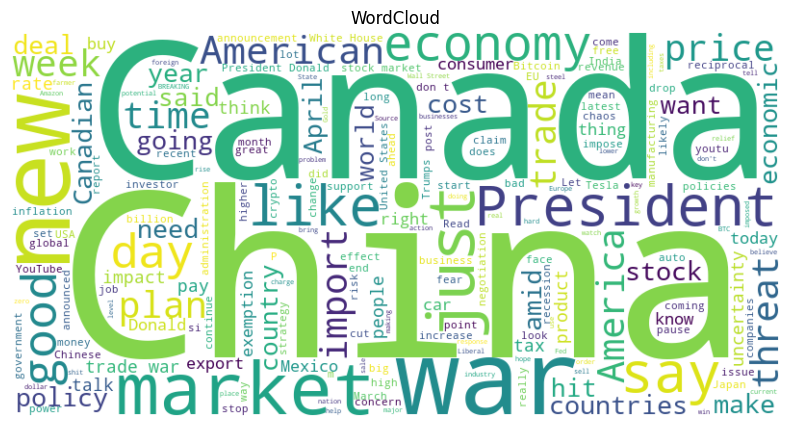

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
custom_stopwords = set(['tariff', 'tariffs', 'trump', 'http', 'https', 'S', 'U'])
all_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stopwords))
def wordcloud(df):
    text = " ".join(df['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=all_stopwords).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud")
wordcloud(df)

In [9]:
df_canada = df[df['text'].str.contains('Canada|Canadian', case=False, na=False)]
df_canada.columns

Index(['Timestamp', 'text', 'sentiment', 'period'], dtype='object')

<Axes: xlabel='Timestamp', ylabel='vader_compound'>

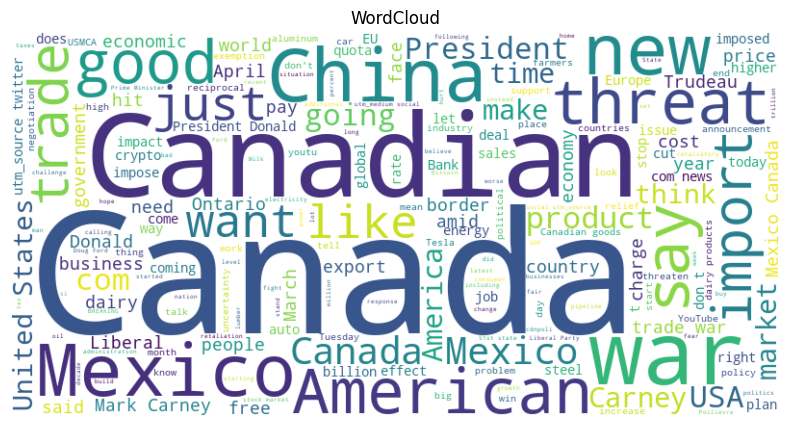

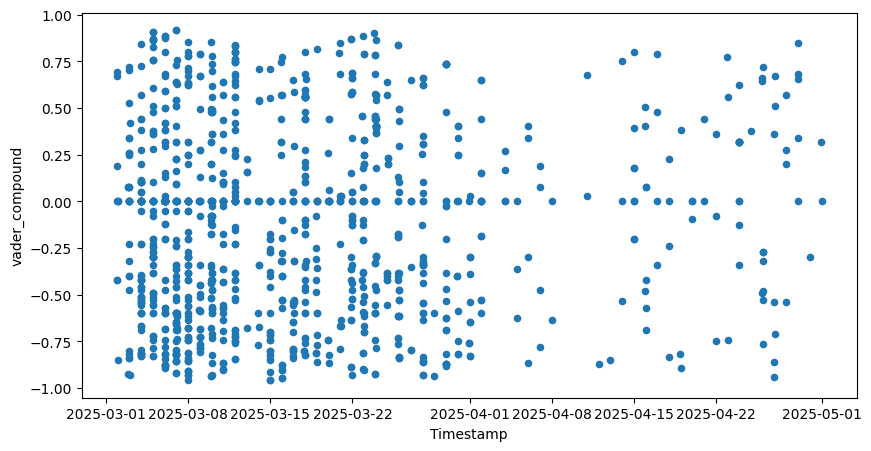

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
df_canada["vader_compound"] = df_canada["text"].astype(str).apply(
    lambda x: analyzer.polarity_scores(x)["compound"])

wordcloud(df_canada)
df_canada.plot.scatter(x='Timestamp', y='vader_compound', figsize=(10, 5))

<Axes: xlabel='Timestamp', ylabel='vader_compound'>

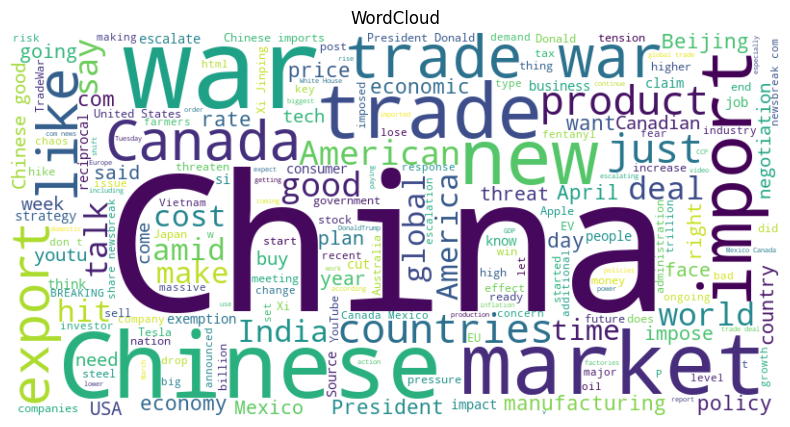

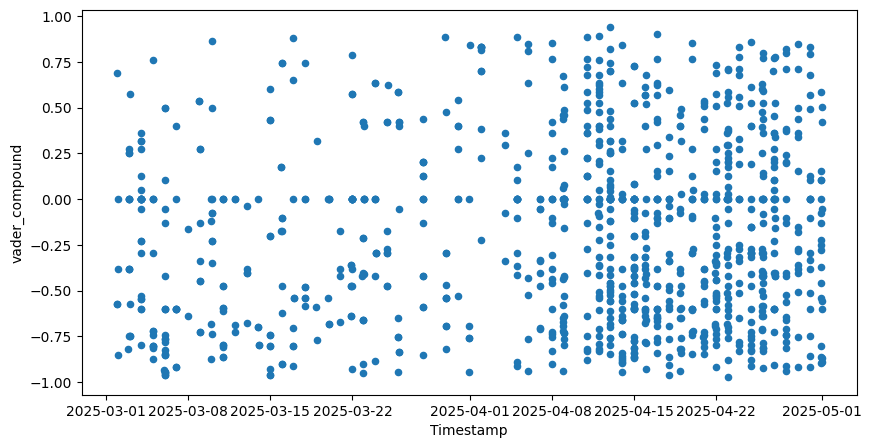

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
df_china = df[df['text'].str.contains('China|Chinese', case=False, na=False)]
df_china["vader_compound"] = df_china["text"].astype(str).apply(
    lambda x: analyzer.polarity_scores(x)["compound"])

wordcloud(df_china)
df_china.plot.scatter(x='Timestamp', y='vader_compound', figsize=(10, 5))

/var/folders/xw/sscnc6jx4kb4klgrdr8sgyz80000gn/T/ipykernel_982/104718283.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mexico["vader_compound"] = df_mexico["text"].astype(str).apply(


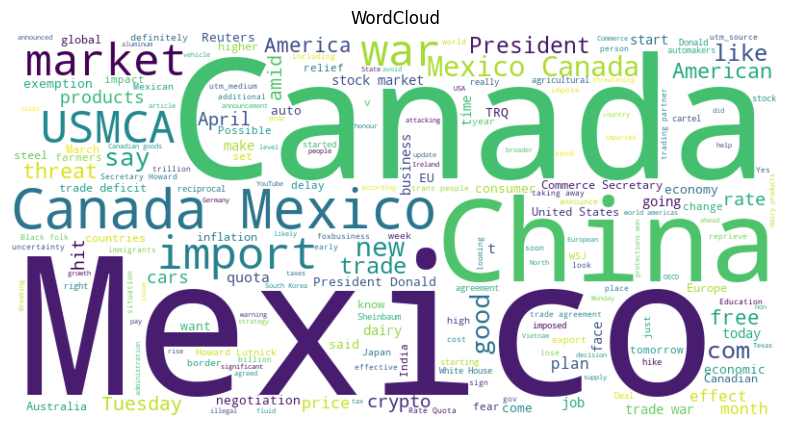

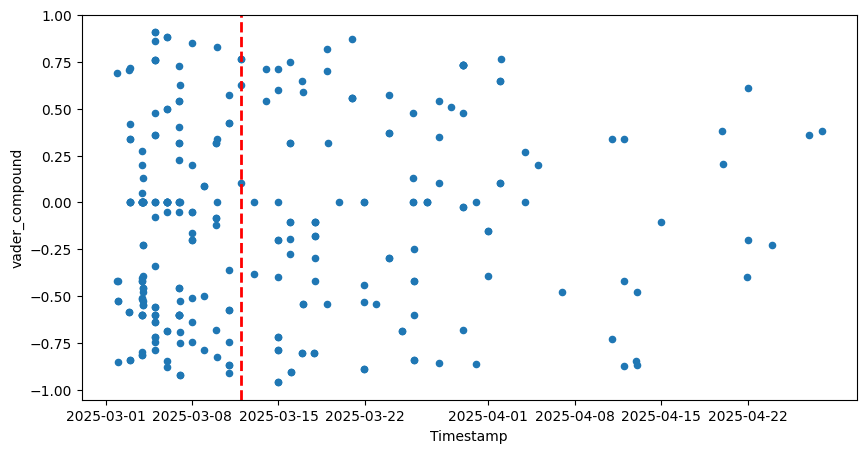

In [ ]:
df_mexico = df[df['text'].str.contains('Mexico|Mexician|USMCA', case=False, na=False)]
wordcloud(df_mexico)
df_mexico["vader_compound"] = df_mexico["text"].astype(str).apply(
    lambda x: analyzer.polarity_scores(x)["compound"])
df_mexico.plot.scatter(x='Timestamp', y='vader_compound', figsize=(10, 5))
event_date = pd.to_datetime('2025-03-12')
plt.axvline(x=event_date, color='red', linestyle='--', linewidth=2, label='March 13, 2025 (Event Date)')

/var/folders/xw/sscnc6jx4kb4klgrdr8sgyz80000gn/T/ipykernel_1006/615203067.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_product["vader_compound"] = df_product["text"].astype(str).apply(


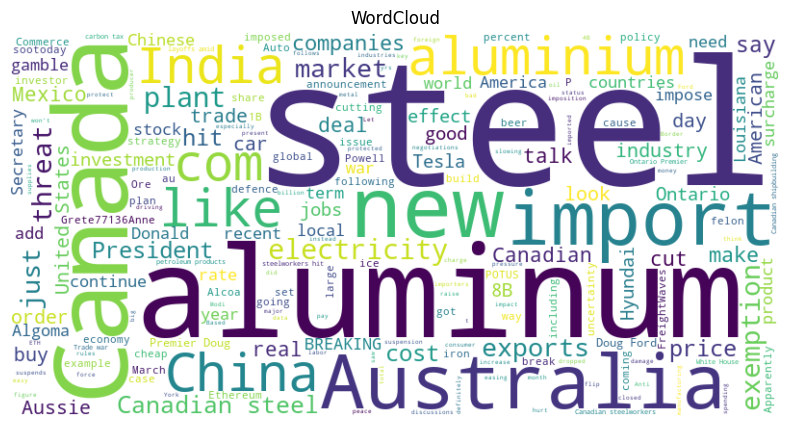

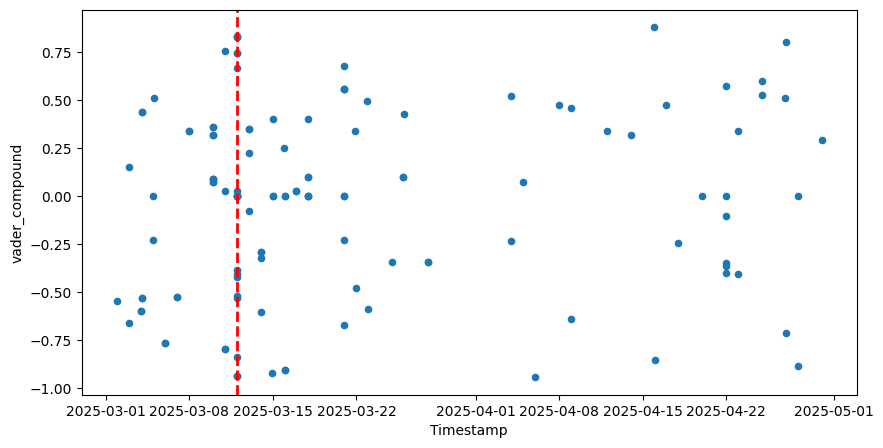

In [18]:
df_product = df[df['text'].str.contains('steel|aluminum|aluminium', case=False, na=False)]
wordcloud(df_product)
df_product["vader_compound"] = df_product["text"].astype(str).apply(
    lambda x: analyzer.polarity_scores(x)["compound"])
df_product.plot.scatter(x='Timestamp', y='vader_compound', figsize=(10, 5))
event_date = pd.to_datetime('2025-03-12')
plt.axvline(x=event_date, color='red', linestyle='--', linewidth=2, label='March 13, 2025 (Event Date)')

In [ ]:
# --- 7. È°çÂ§ñÂàÜÊûêËº∏Âá∫Ôºö‰∫ã‰ª∂ÂâçÂæåÂêÑÁæ§Êï∏ÈáèËàáÊÉÖÁ∑íÂàÜÂ∏É ---
print("\nüìä ÂêÑÁæ§ÊÉÖÁ∑íÊØî‰æãÔºàrow-normalizedÔºâ:")
print(df.groupby('cluster')['sentiment'].value_counts(normalize=True).unstack().fillna(0))

print("\nüìÜ ÂêÑÁæ§Âú®‰∫ã‰ª∂Ââç/ÂæåÁöÑÊØî‰æãÔºàrow-normalizedÔºâ:")
print(pd.crosstab(df['cluster'], df['period'], normalize='index'))


üìä ÂêÑÁæ§ÊÉÖÁ∑íÊØî‰æãÔºàrow-normalizedÔºâ:
sentiment  negative   neutral  positive
cluster                                
0          0.501894  0.174242  0.323864
1          0.536533  0.127507  0.335960
2          0.549412  0.164706  0.285882
3          0.380933  0.251810  0.367257
4          0.504292  0.194421  0.301288
5          0.425767  0.164417  0.409816

üìÜ ÂêÑÁæ§Âú®‰∫ã‰ª∂Ââç/ÂæåÁöÑÊØî‰æãÔºàrow-normalizedÔºâ:
period      after    before
cluster                    
0        0.087121  0.912879
1        0.376074  0.623926
2        0.749412  0.250588
3        0.417136  0.582864
4        0.419742  0.580258
5        0.446626  0.553374


### üåü ‰∫ÆÈªûËßÄÂØüÁ∏ΩÁµêÔºà‰∫ã‰ª∂ÁÇ∫ 4/4 ËÇ°Â∏ÇÊö¥Ë∑åÔºâ

- **Cluster 2Ôºö‰∫ã‰ª∂ÂæåÊøÄÂ¢ûÔºåÂèçÊò†‰∏≠ÁæéË≤øÊòìËàáËÇ°Â∏ÇÈÄ£ÂãïÊÅêÊÖå**  
  Ë©≤Áæ§‰ª• `China`, `war`, `tariffs`, `deal`, `talk` ÁÇ∫Ê†∏ÂøÉË©ûÂΩôÔºåËÅöÁÑ¶‰∏≠ÁæéË°ùÁ™ÅËàáÊîøÁ≠ñ‰∫§Èãí„ÄÇ  
  Êúâ **74.9% Êé®ÊñáÂá∫ÁèæÂú®‰∫ã‰ª∂Âæå**Ôºå‰∏î **Ë≤†Èù¢ÊÉÖÁ∑íÈ´òÈÅî 54.9%**ÔºåÊòØÂ∞ç 4/4 Â∏ÇÂ†¥Ë°ùÊìäÂèçÊáâÊúÄÁõ¥Êé•ÁöÑ‰∏ÄÁæ§„ÄÇ

- **Cluster 0Ôºö‰ª•Âä†ÊãøÂ§ßË¶ñËßíË®éË´ñË≤øÊòìÊîøÁ≠ñÔºåÊ≠∑Âè≤ÊàêÂàÜËºÉÈ´ò**  
  ÈóúÈçµË©ûÂ¶Ç `Canada`, `Trudeau`, `threat`, `tariffs`, `American` ÊåáÂá∫ÂÖ∂ÁÑ¶ÈªûÂú®Âä†ÁæéË≤øÊòìÁà≠Á´ØÔºå  
  **91.3% ÁôºË°®Êñº‰∫ã‰ª∂Ââç**ÔºåÈ°ØÁ§∫Ê≠§ÁÇ∫Êó©ÊúüË≠∞È°åÔºåËàá 4/4 ËÇ°ÁÅΩÁõ∏ÈóúÊÄß‰∏çÈ´ò„ÄÇ

- **Cluster 1ÔºöÊäïË≥á‰∫∫ËßÄÈªûÈ°ØËëóÔºåÂ±ïÁèæÂ∏ÇÂ†¥ÊÜÇÊÖÆËàáÊ≥¢ÂãïÈ†êÊúü**  
  ‰ª• `market`, `stock`, `investor`, `recession`, `Bitcoin` Á≠âË©ûÁÇ∫‰∏ªÔºåË™ûÊ∞£ÂÅèÁÑ¶ÊÖÆ„ÄÇ  
  **37.6% Êé®Êñá‰æÜËá™‰∫ã‰ª∂Âæå**Ôºå‰∏î **Ë≤†Èù¢ÊÉÖÁ∑íÁÇ∫ 53.7%**ÔºåÂèçÊò†ÈáëËûçÂ∏ÇÂ†¥Â∞çÂà©Á©∫Ê∂àÊÅØÈ´òÂ∫¶ÊïèÊÑü„ÄÇ

- **Cluster 3ÔºöÂÉπÊ†ºËàáÊ∂àË≤ªÂ±§Èù¢Ë®éË´ñÔºåÂÖ∑Á∂ìÊøüÁêÜÊÄßÂàÜÊûêÁâπÂæµ**  
  Ë©ûÂΩôÂ¶Ç `price`, `cost`, `consumer`, `import`, `pay`ÔºåË™ûÊ∞£ËºÉ‰∏≠ÊÄß„ÄÅÂàÜÊûêÂ∞éÂêë„ÄÇ  
  Èõñ **41.7% ÁÇ∫‰∫ã‰ª∂ÂæåË≤ºÊñá**Ôºå‰ΩÜÂÖ∂Ë≤†Èù¢ÊÉÖÁ∑íÊØî‰æãÂÉÖÁÇ∫ 38.1%ÔºåÂ±¨ÊñºÊÉÖÁ∑íËºÉÂπ≥Ë°°ÁöÑÁæ§È´î„ÄÇ

- **Cluster 4ÔºöÈõÜ‰∏≠ÊîøÂ∫úË®ÄË´ñËàáÂÆèËßÄÊîøÁ≠ñË©ïË´ñÔºåË™ûÊ∞£ÂÅèÊîøÊ≤ªÊÄß**  
  È´òÈ†ªË©ûÂ¶Ç `President`, `plan`, `policy`, `economy`, `Donald`ÔºåÂèçÊò†ÊîøÊ≤ªÈ†òÂ∞éËàáÁ∂ìÊøüÊà∞Áï•Ë®éË´ñ„ÄÇ  
  Á¥Ñ **42% Êé®ÊñáÁÇ∫‰∫ã‰ª∂Âæå**ÔºåË≤†Èù¢ÊÉÖÁ∑í‰πüÈÅî **50.4%**Ôºå‰ª£Ë°®ÊîøÁ∂ìË≠∞È°åÂú®ËÇ°ÁÅΩÂæå‰ªçÂÖ∑Ë®éË´ñÁÜ±Â∫¶„ÄÇ

- **Cluster 5ÔºöÁ§æÁæ§Ë™ûË®ÄÊ¥ªË∫çÔºåÂè£Ë™ûÂåñËàáÊÉÖÁ∑íÊ≥¢ÂãïÊòéÈ°Ø**  
  ‰ΩøÁî® `just`, `war`, `day`, `like`, `President`, `threat` Á≠âË©ûÂΩôÔºåÂ∏∂ÊúâÂç≥ÊôÇË©ïË´ñËàáÁ∂≤Ê∞ëË™ûÊÑü„ÄÇ  
  ÁÇ∫Ê≠£Èù¢ÊÉÖÁ∑íÊúÄÈ´òÁæ§Ôºà**40.9%**ÔºâÔºå**44.7% ÁÇ∫‰∫ã‰ª∂ÂæåË≤ºÊñá**ÔºåÂèØËÉΩÂåÖÂê´ÂπΩÈªò„ÄÅÊà≤Ë¨îÊàñÊîØÊåÅÁôºË®Ä„ÄÇ


#### Stock market related

In [ ]:
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

event_date = pd.to_datetime("2025-04-04").tz_localize("UTC")
same_day_df = df[df['Timestamp'].dt.date == event_date.date()]

vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X_count = vectorizer.fit_transform(same_day_df['text'])

word_counts = X_count.sum(axis=0).A1
vocab = vectorizer.get_feature_names_out()
top_words = pd.DataFrame({'word': vocab, 'count': word_counts})
top_words = top_words.sort_values(by='count', ascending=False).head(30)

plt.figure(figsize=(10, 6))
plt.barh(top_words['word'][::-1], top_words['count'][::-1])
plt.title("üîç Top Keywords on 2025-04-04 (Stock Plunge Day)")
plt.xlabel("Frequency")
plt.tight_layout()
plt.savefig("saved_imgs_0404/event_day_top_words.png")
plt.close()

## 0409 (È°çÂ§ñÈóúÁ®ÖÁ¨¨‰∏ÄÊ≥¢ÊñΩÂä†)


In [ ]:
csv_files = sorted(glob.glob("data/tariff_data_en/*.csv"))
df_list = [pd.read_csv(f) for f in csv_files]
df = pd.concat(df_list, ignore_index=True)
df.head()

Timestamp  \
0  2025-03-01T22:17:49.000Z   
1  2025-03-01T22:27:25.000Z   
2  2025-03-01T23:00:01.000Z   
3  2025-03-01T23:00:01.000Z   
4  2025-03-01T22:30:20.000Z   

                                       Tweet Content sentiment  
0  Proposed tariffs on China, Canada, and Mexico ...  positive  
1  President Trump says his 25-percent tariff on ...  positive  
2  "You should pay less for someone that has tari...  negative  
3  "You should pay less for someone that has tari...  negative  
4  Beer Companies Say Trump‚Äôs Aluminum Tariff Wil...  negative

In [ ]:
df.columns = ['Timestamp', 'text', 'sentiment']
df.dropna(subset=['text'], inplace=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp']) 
event_date = pd.to_datetime("2025-04-09").tz_localize("UTC")
df['period'] = df['Timestamp'].apply(lambda x: 'before' if x < event_date else 'after')

model = SentenceTransformer('all-MiniLM-L6-v2') 
X = model.encode(df['text'].tolist(), show_progress_bar=True)

Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 280/280 [00:13<00:00, 21.22it/s]


In [ ]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

os.makedirs("saved_imgs_0409", exist_ok=True)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='tab10', alpha=0.6)
plt.title("KMeans with SBERT Embedding (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label='Cluster')
plt.savefig("saved_imgs_0409/kmeans_pca_sbert.png")
plt.close()

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
custom_stopwords = set(['tariff', 'trump'])
all_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stopwords))

def plot_cluster_wordcloud(df, cluster_num):
    text = " ".join(df[df['cluster'] == cluster_num]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=all_stopwords).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Cluster {cluster_num} WordCloud")
    plt.savefig(f"saved_imgs_0409/cluster_{cluster_num}_wordcloud_sbert.png")
    plt.close()

for cl in sorted(df['cluster'].unique()):
    plot_cluster_wordcloud(df, cl)

In [ ]:
print("\nÂêÑÁæ§ÊÉÖÁ∑íÊØî‰æãÔºàrow-normalizedÔºâ:")
print(df.groupby('cluster')['sentiment'].value_counts(normalize=True).unstack().fillna(0))

print("\nÂêÑÁæ§Âú®‰∫ã‰ª∂Ââç/ÂæåÁöÑÊØî‰æãÔºàrow-normalizedÔºâ:")
print(pd.crosstab(df['cluster'], df['period'], normalize='index'))


üìä ÂêÑÁæ§ÊÉÖÁ∑íÊØî‰æãÔºàrow-normalizedÔºâ:
sentiment  negative   neutral  positive
cluster                                
0          0.501894  0.174242  0.323864
1          0.536533  0.127507  0.335960
2          0.549412  0.164706  0.285882
3          0.380933  0.251810  0.367257
4          0.504292  0.194421  0.301288
5          0.425767  0.164417  0.409816

üìÜ ÂêÑÁæ§Âú®‰∫ã‰ª∂Ââç/ÂæåÁöÑÊØî‰æãÔºàrow-normalizedÔºâ:
period      after    before
cluster                    
0        0.072917  0.927083
1        0.315903  0.684097
2        0.652941  0.347059
3        0.327836  0.672164
4        0.333047  0.666953
5        0.391411  0.608589


### üìã Áæ§È´îË™ûÊÑèÁ∏ΩË¶ΩË°®Ê†ºÔºàÊï¥ÂêàË™ûÊÑè„ÄÅÊÉÖÁ∑íËàáÊôÇÈñìÔºâ

| Cluster | ‰∏ªÈ°åÁÑ¶Èªû                         | È´òÈ†ªÈóúÈçµË©ûÔºàÈÉ®ÂàÜÔºâ                           | Ë™ûÊ∞£ÂÇæÂêë       | Ë≤†Èù¢ÊÉÖÁ∑íÊØî‰æã | ‰∫ã‰ª∂Âæå‰ΩîÊØî | ÂÇôË®ª                             |
|---------|----------------------------------|----------------------------------------------|----------------|----------------|------------|----------------------------------|
| 0       | ÁæéÂä†Ë≤øÊòìÁà≠Á´ØËàáÂä†ÊãøÂ§ßËßÄÈªû         | Canada, Trudeau, threat, tariffs, product    | ÊâπÂà§„ÄÅÈò≤Á¶¶Âûã   | 50.2%         | 7.3%       | Âπæ‰πéÁöÜÂú®‰∫ã‰ª∂ÂâçÂá∫ÁèæÔºåÁÇ∫Ê≠∑Âè≤Ë≠∞È°å   |
| 1       | Â∏ÇÂ†¥Ê≥¢ÂãïËàáÊäïË≥áÂèçÊáâ               | stock, market, investor, inflation, Bitcoin  | ÁÑ¶ÊÖÆ„ÄÅÁêÜÊÄßÂûã   | 53.7%         | 31.6%      | ÈóúÊ≥®ËÇ°Â∏ÇËàáÈáëËûçË°ùÊìä               |
| 2       | ‰∏≠ÁæéË≤øÊòìÊà∞ËàáÂúãÈöõË´áÂà§             | China, deal, war, export, talk               | Â∞çÁ´ã„ÄÅÊâπÂà§Âûã   | 54.9%         | 65.3%      | Ëàá‰∫ã‰ª∂È´òÂ∫¶Áõ∏ÈóúÔºå‰∫ã‰ª∂ÂæåÊøÄÂ¢û       |
| 3       | ÈóúÁ®ÖÂΩ±ÈüøËàáÊ∂àË≤ªÁ∂ìÊøü               | tariffs, price, cost, consumer, product      | ‰∏≠ÊÄß„ÄÅÁêÜÊÄßÂûã   | 38.1%         | 32.8%      | Ê∂âÂèäÊ∞ëÁîüÁâ©ÂÉπËàáÈÄ≤Âá∫Âè£Á®ÖÊî∂         |
| 4       | ÊîøÁ≠ñË©ïË´ñËàáÂÆòÊñπË®ÄË´ñÂèçÊáâ           | President, economy, policy, plan             | Ë©ïË´ñÊÄßÊ∑∑ÂêàÂûã   | 50.4%         | 33.3%      | Ê∂âÂèäÊîøÂ∫úÁôºË®ÄËàáÊîøÁ≠ñÊñπÂêë           |
| 5       | Á∂≤Ê∞ëËºøË´ñËàáÁ§æÁæ§Âè£Ë™ûÂèçÊáâ           | just, like, say, new, talk, war              | Â§öÂÖÉ„ÄÅÊÉÖÁ∑íÂåñ   | 42.6%         | 39.1%      | Á§æÁæ§ÊÑèË¶ãËá™Áî±ÁôºË°®ÔºåÊÉÖÁ∑íÊ≥¢ÂãïÂ§ß     |


### üåü ‰∫ÆÈªûËßÄÂØüÁ∏ΩÁµê

- **Cluster 2 ÊòØ‰∫ã‰ª∂ÂæåÂèçÊáâÊúÄÂº∑ÁÉàÁöÑÁæ§È´î**  
  Ê≠§Áæ§‰ª•„Äå‰∏≠ÁæéË≤øÊòìÊà∞„ÄçÁÇ∫Ê†∏ÂøÉ‰∏ªÈ°åÔºåÂåÖÂê´Â§ßÈáèÂ¶Ç `China`, `war`, `deal`, `export` Á≠âÂ∞çÁ´ãÊÄßË©ûÂΩô„ÄÇ  
  Êé®Êñá‰∏≠Êúâ **Ë∂ÖÈÅé 65% Âá∫ÁèæÂú®‰∫ã‰ª∂Âæå**Ôºå‰∏î **Ë≤†Èù¢ÊÉÖÁ∑í‰ΩîÊØîÈ´òÈÅî 54.9%**ÔºåÈ°ØÁ§∫‰∫ã‰ª∂ÂèØËÉΩÂºïÁôº‰∫ÜÂ§ßÈáè‰∏çÂÆâËàáÊâπÂà§Ë®ÄË´ñ„ÄÇ

- **Cluster 0 Âπæ‰πéÂÖ®ÈÉ®ÁÇ∫‰∫ã‰ª∂ÂâçÁöÑÊ≠∑Âè≤Ë≠∞È°å**  
  ËÅöÁÑ¶„ÄåÁæéÂä†Ë≤øÊòìÁà≠Á´Ø„ÄçËàáÂä†ÊãøÂ§ßËßíÂ∫¶ÔºàË©ûÂΩôÂ¶Ç `Canada`, `Trudeau`, `threat`ÔºâÔºå  
  **‰∫ã‰ª∂ÂæåÂÉÖ‰Ωî 7.3%**ÔºåË™™ÊòéÊ≠§‰∏ªÈ°åÂèØËÉΩÂ∑≤ÈÄêÊº∏ÈôçÊ∫´Ôºå‰∏îË®éË´ñÈõÜ‰∏≠ÊñºÈÅéÂæÄÊîøÁ≠ñËàáÂΩ±Èüø„ÄÇ

- **Cluster 5 ÁÇ∫ÊÉÖÁ∑íÊúÄÊ≠£ÂêëÁöÑÁæ§È´îÔºåË™ûË®ÄÈ¢®Ê†ºÂÅèÁ§æÁæ§ËàáÂè£Ë™ûÂåñ**  
  Â∏∏Ë¶ãË©ûÂΩôÂ¶Ç `just`, `like`, `say`, `want`ÔºåÈ°ØÁ§∫Áî®Ë™ûËá™ÁÑ∂„ÄÅËºïÈ¨ÜÔºåÁ¨¶ÂêàÁ§æ‰∫§Âπ≥Âè∞ÁâπÂæµ„ÄÇ  
  **Ê≠£ÂêëÊÉÖÁ∑í‰ΩîÊØîÈÅî 40.9%**ÔºåÁÇ∫ÂÖ≠Áæ§‰πãÊúÄÔºåÂëàÁèæËºøË´ñËá™Áî±Ë°®ÈÅîËàáÈÉ®ÂàÜÂπΩÈªòÊàñÊîØÊåÅÊÄßË™ûÊ∞£„ÄÇ

- **Cluster 3 Ë®éË´ñÁÑ¶ÈªûÂÅèÂêëÁ∂ìÊøüË≤†ÊìîËàáÊ∂àË≤ªËÄÖËßíÂ∫¶**  
  ÈóúÊ≥®Â¶Ç `cost`, `price`, `consumer`, `impact` Á≠âË©ûÂΩôÔºåË™ûÊ∞£Êï¥È´îÂÅè‰∏≠ÊÄßËàáÁêÜÊÄß„ÄÇ  
  Èõñ‰∏çÂ±¨ÊñºÊÉÖÁ∑íÊ•µÁ´ØÁæ§È´îÔºå‰ΩÜ‰πüÂÖ∑ÂÇôÈï∑ÊúüË®éË´ñÂÉπÂÄºÔºåÂèçÊò†ÊîøÁ≠ñÂ∞çÁîüÊ¥ªÂ±§Èù¢ÁöÑÂØ¶ÈöõÂΩ±Èüø„ÄÇ

- **Cluster 1 Ë°®ÁèæÂá∫Â∞çÂ∏ÇÂ†¥ÁöÑÁÑ¶ÊÖÆËàáËßÄÊúõÊÉÖÁ∑í**  
  ‰∏ªÈ°åÈõÜ‰∏≠Êñº `stock`, `market`, `investor`, `recession` Á≠âË©ûÔºå  
  ‰∏¶Êúâ **53.7% ÁöÑË≤†Èù¢ÊÉÖÁ∑í**ÔºåÈ°ØÁ§∫Á∂ìÊøü‰∏çÁ¢∫ÂÆöÊÄßÂºïÁôºÁöÑÊäïË≥áÊÜÇÊÖÆÊôÆÈÅçÂ≠òÂú®„ÄÇ

- **Cluster 4 Ê∂âÂèäÊîøÂ∫úËàáÈ†òÂ∞é‰∫∫Ë®ÄË´ñÔºåÊÉÖÁ∑íÂÖ©Ê•µÂåñ**  
  È´òÈ†ªË©ûÂåÖÂê´ `President`, `policy`, `plan`, `economy`ÔºåÊ∂âÂèäÂÆòÊñπÁôºË®ÄËàáÊîøË¶ã„ÄÇ  
  ÈõñÂàÜÂ∏ÉÁ©©ÂÆöÔºå‰ΩÜÊÉÖÁ∑íÂÆπÊòìÈö®Á´ãÂ†¥ËÆäÂåñËÄåÂàÜÂåñÔºåÂëàÁèæË©ïË´ñÊÄßËàáÂ∞çÁ´ãÊÄßÊ∑∑ÂêàË™ûÊ∞£„ÄÇ
